In [137]:
from __future__ import print_function
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim.lr_scheduler import MultiStepLR
from models.model_v2 import spk_vq_vae_resnet
from models.utils import Helper
from torchsummary import summary
from sklearn.metrics import mean_squared_error

gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [138]:
# %% parameters passed to data loader
import collections
args = collections.namedtuple

# args.train_data_path = './data/wave_clus_noise01_c4.mat'
# args.test_data_path = './data/wave_clus_noise01_c4.mat'

# args.train_data_path = './data/hc1.mat'
# args.test_data_path = './data/hc1.mat'

# args.train_data_path = './data/C_drift.mat'
# args.test_data_path = './data/C_drift.mat'

# args.train_data_path = './data/pac_scream70dB_spks_3d.mat'
# args.test_data_path = './data/pac_scream70dB_spks_3d.mat'

# args.train_data_path = './data/C_difficult1_spks_c4.mat'
# args.test_data_path = './data/C_difficult1_spks_c4.mat'

# args.train_data_path = './data/C_easy1_spks_c4.mat'
# args.test_data_path = './data/C_easy1_spks_c4.mat'

args.train_data_path = './data/Neuropixels_spks_c15_random.mat'
args.test_data_path = './data/Neuropixels_spks_c15_random.mat'

# args.train_data_path = './data/Neuropixels_sync_spks.mat'
# args.test_data_path = './data/Neuropixels_sync_spks.mat'

args.train_ratio = .6
args.test_ratio = .4
args.seed = 1
args.batch_size = 48
args.test_batch_size = 128
args.randperm = True

if args.train_data_path is not args.test_data_path:
	args.val_norm = True
else:
	args.val_norm = False

# %% global parameters
spk_ch = 15
args.spk_ch = spk_ch
spk_dim = 48
log_interval = 50
beta = 0.15
vq_num = 512

"""
org_dim     = param[0]
conv1_ch    = param[1]
conv2_ch    = param[2]
conv1_ker   = param[4]
conv2_ker   = param[5]
self.vq_dim = param[6]
self.vq_num = param[7]
cardinality = param[8]
vq on chan  = param[9]
"""
param_resnet_v2 = [spk_ch, 256, 120, 1, 3, 1, 12, vq_num, 16, 4, False, 0.2]

# %% train/test splitting and normalization
helper = Helper(args)
train_loader, test_loader = helper.create_data_loaders()

In [139]:
# %%
model = spk_vq_vae_resnet(param_resnet_v2).to(gpu)
#summary(model, (spk_ch, spk_dim))
#model.load_state_dict(torch.load('./cae_models/spk_vq_vae_hc1_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2])))

In [140]:
# %%
def l1_loss():
	l1_reg = Variable(torch.FloatTensor(1), requires_grad=True).cuda()
	for w in model.embed.parameters():
		l1_reg += w.norm(1)
	return l1_reg * 1e-1

def loss_function(recon_x, x, commit_loss, vq_loss):
    recon_loss = F.mse_loss(recon_x, x, size_average=False)
    return recon_loss + beta * commit_loss + vq_loss, recon_loss
    #return recon_loss + vq_loss, recon_loss

# def loss_function(recon_x, x, commit_loss, vq_loss):
#     recon_loss = 8.685889638065037 * torch.log(torch.norm(x, p=2, dim=2) / torch.norm(recon_x-x, p=2, dim=2))
#     return recon_loss + beta * commit_loss + vq_loss, recon_loss

In [141]:
# %%
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4, amsgrad=True)
#optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-5, momentum=0.9)
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-6)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=.9)

# decay_embed, decay_rest = [], []
# for name, param in model.named_parameters():
#     if 'embed' in name:
#         decay_embed.append(param)
#     else:
#         decay_rest.append(param)

# optimizer = optim.SGD([
#     {'params': decay_rest, 'weight_decay':1e-4},
#     {'params': decay_embed, 'weight_decay':1e-5, 'momentum':0.9}
#     ], lr=1e-9, momentum=0.9)

scheduler = MultiStepLR(optimizer, milestones=[250,350,600], gamma=0.1)

In [142]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        #data = Variable(data).cuda()
        data = data.to(gpu)

        optimizer.zero_grad()
        recon_batch, commit_loss, vq_loss = model(data)
        loss, recon_loss = loss_function(recon_batch, data, commit_loss, vq_loss)
        loss.backward(retain_graph=True)
        model.bwd()
        optimizer.step()
        
        #train_loss += recon_loss.data[0] * len(data)
        train_loss += recon_loss.item() / (spk_dim * spk_ch)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), recon_loss.item()))

    #print(model.embed.weight.data)
    
    average_train_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average train loss: {:.5f}'.format(
          epoch, average_train_loss))
    return average_train_loss

In [143]:
# %% save model
best_val_loss = 10 # v3
cur_train_loss = 1
#best_val_loss = .3965 # v1
def save_model(val_loss, train_loss):
	global best_val_loss, cur_train_loss
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		cur_train_loss = train_loss
		torch.save(model.state_dict(), './spk_vq_vae_temp.pt')

In [144]:
# %%
def test(epoch):
    model.eval()
    model.embed_reset()
    test_loss = 0
    recon_sig = torch.rand(1, spk_ch, spk_dim)
    org_sig = torch.rand(1, spk_ch, spk_dim)
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data = data.to(gpu)

            recon_batch, commit_loss, vq_loss = model(data)
            _, recon_loss = loss_function(recon_batch, data, commit_loss, vq_loss)
        
            recon_sig = torch.cat((recon_sig, recon_batch.data.cpu()), dim=0)
            org_sig = torch.cat((org_sig, data.data.cpu()), dim=0)
        
            #test_loss += recon_loss.data[0] * len(data)
            test_loss += recon_loss.item() / (spk_dim * spk_ch)

        average_test_loss = test_loss / len(test_loader.dataset)
        print('====> Epoch: {} Average test loss: {:.5f}'.format(
              epoch, average_test_loss))

    if epoch % 10 == 0:
        plt.figure(figsize=(15,5))
        plt.bar(np.arange(vq_num), model.embed_freq / model.embed_freq.sum())
        plt.show()

    return average_test_loss, recon_sig[1:], org_sig[1:]

In [145]:
# def test_batch():
# 	model.eval()
# 	_, _, data = helper.param_for_recon()
# 	data = Variable(torch.from_numpy(data)).cuda()
# 	results, commit_loss = model(data)
# 	_, recon_loss = loss_function(results, data, commit_loss)
# 	print('Average test loss: {:.4f}'.format(recon_loss.data[0]))
# 	return recon_loss, results

In [146]:
# %% training and validating
train_loss_history = []
test_loss_history = []

Train Epoch: 1 [0/1800 (0%)]	Loss: 46175.1836
====> Epoch: 1 Average train loss: 1.04743
====> Epoch: 1 Average test loss: 0.94433
Train Epoch: 2 [0/1800 (0%)]	Loss: 30892.6133
====> Epoch: 2 Average train loss: 0.79266
====> Epoch: 2 Average test loss: 0.60238
Train Epoch: 3 [0/1800 (0%)]	Loss: 24267.4453
====> Epoch: 3 Average train loss: 0.66710
====> Epoch: 3 Average test loss: 0.48711
Train Epoch: 4 [0/1800 (0%)]	Loss: 21340.1094
====> Epoch: 4 Average train loss: 0.58703
====> Epoch: 4 Average test loss: 0.42779
Train Epoch: 5 [0/1800 (0%)]	Loss: 19652.2031
====> Epoch: 5 Average train loss: 0.53690
====> Epoch: 5 Average test loss: 0.38970
Train Epoch: 6 [0/1800 (0%)]	Loss: 17536.0762
====> Epoch: 6 Average train loss: 0.49899
====> Epoch: 6 Average test loss: 0.36366
Train Epoch: 7 [0/1800 (0%)]	Loss: 16983.8398
====> Epoch: 7 Average train loss: 0.47122
====> Epoch: 7 Average test loss: 0.34263
Train Epoch: 8 [0/1800 (0%)]	Loss: 15755.5322
====> Epoch: 8 Average train loss: 0.

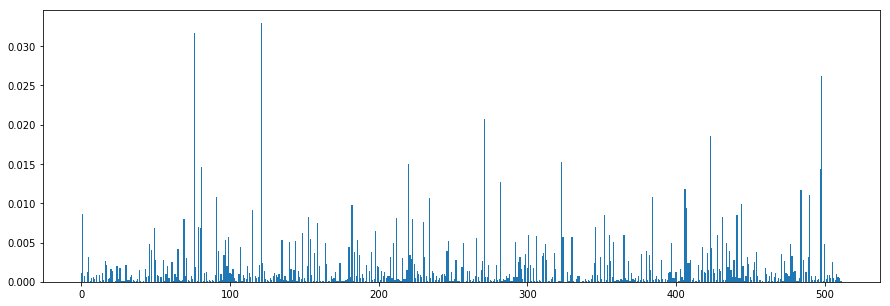

Train Epoch: 11 [0/1800 (0%)]	Loss: 13676.5752
====> Epoch: 11 Average train loss: 0.40127
====> Epoch: 11 Average test loss: 0.29086
Train Epoch: 12 [0/1800 (0%)]	Loss: 12950.9297
====> Epoch: 12 Average train loss: 0.38946
====> Epoch: 12 Average test loss: 0.28271
Train Epoch: 13 [0/1800 (0%)]	Loss: 13285.8311
====> Epoch: 13 Average train loss: 0.37959
====> Epoch: 13 Average test loss: 0.27470
Train Epoch: 14 [0/1800 (0%)]	Loss: 13086.7568
====> Epoch: 14 Average train loss: 0.37114
====> Epoch: 14 Average test loss: 0.26775
Train Epoch: 15 [0/1800 (0%)]	Loss: 12325.1709
====> Epoch: 15 Average train loss: 0.36202
====> Epoch: 15 Average test loss: 0.26163
Train Epoch: 16 [0/1800 (0%)]	Loss: 12254.5869
====> Epoch: 16 Average train loss: 0.35558
====> Epoch: 16 Average test loss: 0.25690
Train Epoch: 17 [0/1800 (0%)]	Loss: 12863.1777
====> Epoch: 17 Average train loss: 0.35013
====> Epoch: 17 Average test loss: 0.25219
Train Epoch: 18 [0/1800 (0%)]	Loss: 11561.4004
====> Epoch: 18

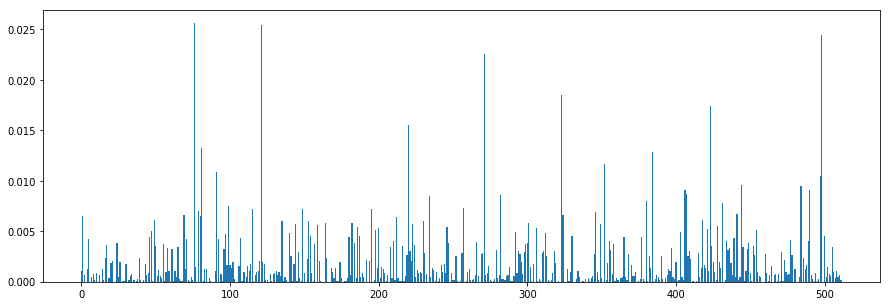

Train Epoch: 21 [0/1800 (0%)]	Loss: 11604.7129
====> Epoch: 21 Average train loss: 0.32841
====> Epoch: 21 Average test loss: 0.23859
Train Epoch: 22 [0/1800 (0%)]	Loss: 11781.9854
====> Epoch: 22 Average train loss: 0.32555
====> Epoch: 22 Average test loss: 0.23531
Train Epoch: 23 [0/1800 (0%)]	Loss: 11201.3789
====> Epoch: 23 Average train loss: 0.32074
====> Epoch: 23 Average test loss: 0.23236
Train Epoch: 24 [0/1800 (0%)]	Loss: 10849.9980
====> Epoch: 24 Average train loss: 0.31783
====> Epoch: 24 Average test loss: 0.23048
Train Epoch: 25 [0/1800 (0%)]	Loss: 10753.4043
====> Epoch: 25 Average train loss: 0.31446
====> Epoch: 25 Average test loss: 0.22856
Train Epoch: 26 [0/1800 (0%)]	Loss: 10623.1270
====> Epoch: 26 Average train loss: 0.31112
====> Epoch: 26 Average test loss: 0.22588
Train Epoch: 27 [0/1800 (0%)]	Loss: 10781.5850
====> Epoch: 27 Average train loss: 0.30806
====> Epoch: 27 Average test loss: 0.22345
Train Epoch: 28 [0/1800 (0%)]	Loss: 9789.0303
====> Epoch: 28 

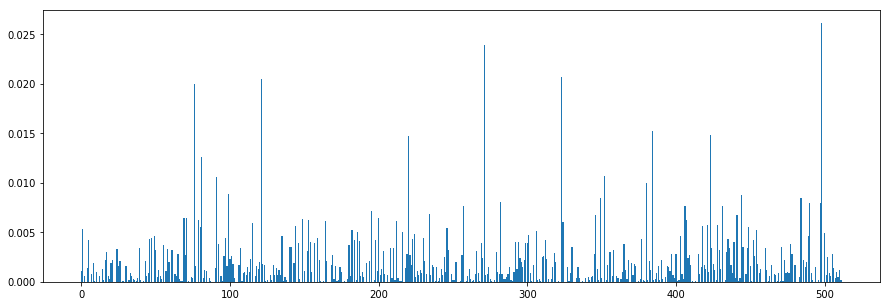

Train Epoch: 31 [0/1800 (0%)]	Loss: 10987.8740
====> Epoch: 31 Average train loss: 0.29705
====> Epoch: 31 Average test loss: 0.21651
Train Epoch: 32 [0/1800 (0%)]	Loss: 10736.1396
====> Epoch: 32 Average train loss: 0.29426
====> Epoch: 32 Average test loss: 0.21490
Train Epoch: 33 [0/1800 (0%)]	Loss: 10306.8398
====> Epoch: 33 Average train loss: 0.29278
====> Epoch: 33 Average test loss: 0.21402
Train Epoch: 34 [0/1800 (0%)]	Loss: 9796.3027
====> Epoch: 34 Average train loss: 0.29027
====> Epoch: 34 Average test loss: 0.21253
Train Epoch: 35 [0/1800 (0%)]	Loss: 10466.9180
====> Epoch: 35 Average train loss: 0.28772
====> Epoch: 35 Average test loss: 0.21158
Train Epoch: 36 [0/1800 (0%)]	Loss: 9695.1621
====> Epoch: 36 Average train loss: 0.28572
====> Epoch: 36 Average test loss: 0.20991
Train Epoch: 37 [0/1800 (0%)]	Loss: 9781.9268
====> Epoch: 37 Average train loss: 0.28511
====> Epoch: 37 Average test loss: 0.20875
Train Epoch: 38 [0/1800 (0%)]	Loss: 9411.5088
====> Epoch: 38 Ave

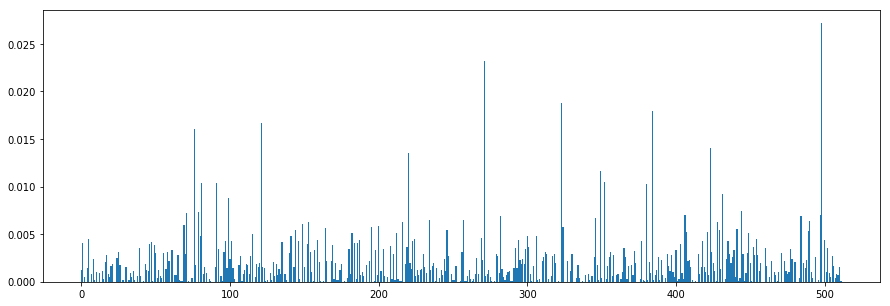

Train Epoch: 41 [0/1800 (0%)]	Loss: 9818.4365
====> Epoch: 41 Average train loss: 0.27763
====> Epoch: 41 Average test loss: 0.20421
Train Epoch: 42 [0/1800 (0%)]	Loss: 9572.7451
====> Epoch: 42 Average train loss: 0.27630
====> Epoch: 42 Average test loss: 0.20338
Train Epoch: 43 [0/1800 (0%)]	Loss: 10246.2920
====> Epoch: 43 Average train loss: 0.27427
====> Epoch: 43 Average test loss: 0.20198
Train Epoch: 44 [0/1800 (0%)]	Loss: 9506.5234
====> Epoch: 44 Average train loss: 0.27290
====> Epoch: 44 Average test loss: 0.20094
Train Epoch: 45 [0/1800 (0%)]	Loss: 9043.7324
====> Epoch: 45 Average train loss: 0.27276
====> Epoch: 45 Average test loss: 0.20072
Train Epoch: 46 [0/1800 (0%)]	Loss: 9273.8496
====> Epoch: 46 Average train loss: 0.26992
====> Epoch: 46 Average test loss: 0.19897
Train Epoch: 47 [0/1800 (0%)]	Loss: 8894.3467
====> Epoch: 47 Average train loss: 0.27008
====> Epoch: 47 Average test loss: 0.19844
Train Epoch: 48 [0/1800 (0%)]	Loss: 9053.5840
====> Epoch: 48 Averag

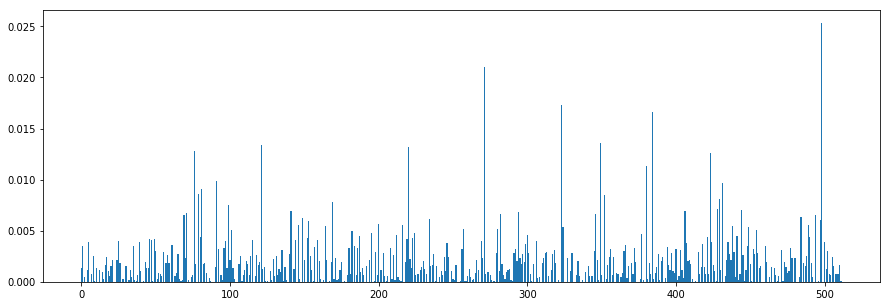

Train Epoch: 51 [0/1800 (0%)]	Loss: 8974.7734
====> Epoch: 51 Average train loss: 0.26512
====> Epoch: 51 Average test loss: 0.19528
Train Epoch: 52 [0/1800 (0%)]	Loss: 9028.1514
====> Epoch: 52 Average train loss: 0.26378
====> Epoch: 52 Average test loss: 0.19471
Train Epoch: 53 [0/1800 (0%)]	Loss: 9601.7549
====> Epoch: 53 Average train loss: 0.26283
====> Epoch: 53 Average test loss: 0.19376
Train Epoch: 54 [0/1800 (0%)]	Loss: 9757.1094
====> Epoch: 54 Average train loss: 0.26133
====> Epoch: 54 Average test loss: 0.19333
Train Epoch: 55 [0/1800 (0%)]	Loss: 8912.2852
====> Epoch: 55 Average train loss: 0.26058
====> Epoch: 55 Average test loss: 0.19268
Train Epoch: 56 [0/1800 (0%)]	Loss: 9274.5000
====> Epoch: 56 Average train loss: 0.25900
====> Epoch: 56 Average test loss: 0.19175
Train Epoch: 57 [0/1800 (0%)]	Loss: 9128.5459
====> Epoch: 57 Average train loss: 0.25807
====> Epoch: 57 Average test loss: 0.19148
Train Epoch: 58 [0/1800 (0%)]	Loss: 8779.6523
====> Epoch: 58 Average

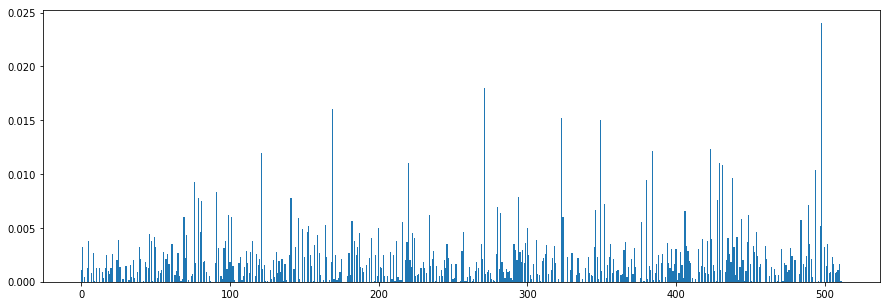

Train Epoch: 61 [0/1800 (0%)]	Loss: 8435.7520
====> Epoch: 61 Average train loss: 0.25461
====> Epoch: 61 Average test loss: 0.18852
Train Epoch: 62 [0/1800 (0%)]	Loss: 8877.0723
====> Epoch: 62 Average train loss: 0.25418
====> Epoch: 62 Average test loss: 0.18872
Train Epoch: 63 [0/1800 (0%)]	Loss: 8364.2588
====> Epoch: 63 Average train loss: 0.25350
====> Epoch: 63 Average test loss: 0.18842
Train Epoch: 64 [0/1800 (0%)]	Loss: 8513.6455
====> Epoch: 64 Average train loss: 0.25272
====> Epoch: 64 Average test loss: 0.18713
Train Epoch: 65 [0/1800 (0%)]	Loss: 8244.2754
====> Epoch: 65 Average train loss: 0.25152
====> Epoch: 65 Average test loss: 0.18715
Train Epoch: 66 [0/1800 (0%)]	Loss: 8452.1016
====> Epoch: 66 Average train loss: 0.25088
====> Epoch: 66 Average test loss: 0.18646
Train Epoch: 67 [0/1800 (0%)]	Loss: 8541.2070
====> Epoch: 67 Average train loss: 0.25072
====> Epoch: 67 Average test loss: 0.18708
Train Epoch: 68 [0/1800 (0%)]	Loss: 8589.5781
====> Epoch: 68 Average

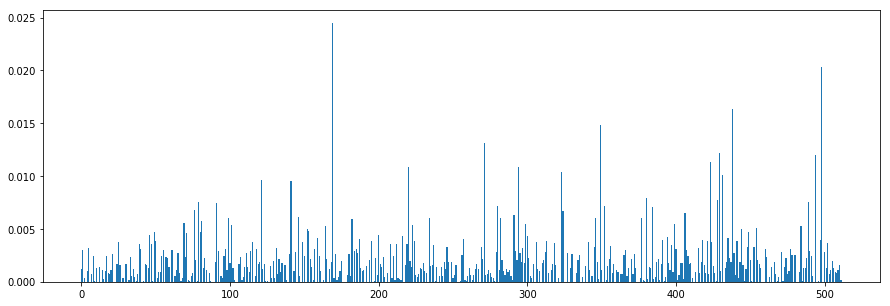

Train Epoch: 71 [0/1800 (0%)]	Loss: 8232.3877
====> Epoch: 71 Average train loss: 0.24814
====> Epoch: 71 Average test loss: 0.18466
Train Epoch: 72 [0/1800 (0%)]	Loss: 8367.6934
====> Epoch: 72 Average train loss: 0.24578
====> Epoch: 72 Average test loss: 0.18424
Train Epoch: 73 [0/1800 (0%)]	Loss: 8505.1816
====> Epoch: 73 Average train loss: 0.24609
====> Epoch: 73 Average test loss: 0.18367
Train Epoch: 74 [0/1800 (0%)]	Loss: 8338.7012
====> Epoch: 74 Average train loss: 0.24523
====> Epoch: 74 Average test loss: 0.18391
Train Epoch: 75 [0/1800 (0%)]	Loss: 8056.5732
====> Epoch: 75 Average train loss: 0.24458
====> Epoch: 75 Average test loss: 0.18241
Train Epoch: 76 [0/1800 (0%)]	Loss: 8389.2432
====> Epoch: 76 Average train loss: 0.24463
====> Epoch: 76 Average test loss: 0.18219
Train Epoch: 77 [0/1800 (0%)]	Loss: 8237.7812
====> Epoch: 77 Average train loss: 0.24393
====> Epoch: 77 Average test loss: 0.18269
Train Epoch: 78 [0/1800 (0%)]	Loss: 8560.5859
====> Epoch: 78 Average

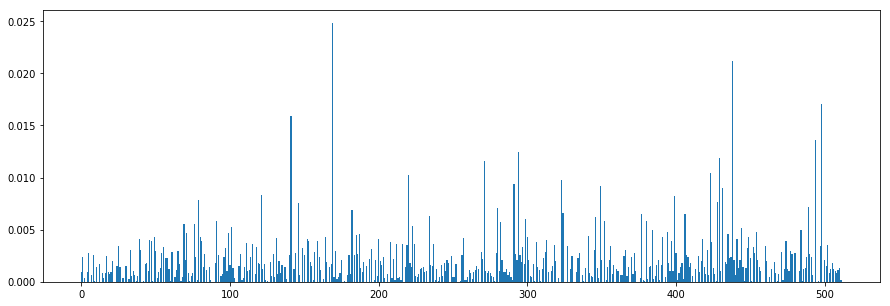

Train Epoch: 81 [0/1800 (0%)]	Loss: 8727.2354
====> Epoch: 81 Average train loss: 0.24191
====> Epoch: 81 Average test loss: 0.18092
Train Epoch: 82 [0/1800 (0%)]	Loss: 7996.5879
====> Epoch: 82 Average train loss: 0.24061
====> Epoch: 82 Average test loss: 0.18091
Train Epoch: 83 [0/1800 (0%)]	Loss: 8617.7793
====> Epoch: 83 Average train loss: 0.24017
====> Epoch: 83 Average test loss: 0.18051
Train Epoch: 84 [0/1800 (0%)]	Loss: 8042.0186
====> Epoch: 84 Average train loss: 0.24121
====> Epoch: 84 Average test loss: 0.18078
Train Epoch: 85 [0/1800 (0%)]	Loss: 8458.2910
====> Epoch: 85 Average train loss: 0.23857
====> Epoch: 85 Average test loss: 0.17951
Train Epoch: 86 [0/1800 (0%)]	Loss: 8126.6860
====> Epoch: 86 Average train loss: 0.23946
====> Epoch: 86 Average test loss: 0.17994
Train Epoch: 87 [0/1800 (0%)]	Loss: 8479.0732
====> Epoch: 87 Average train loss: 0.23901
====> Epoch: 87 Average test loss: 0.17931
Train Epoch: 88 [0/1800 (0%)]	Loss: 8259.4639
====> Epoch: 88 Average

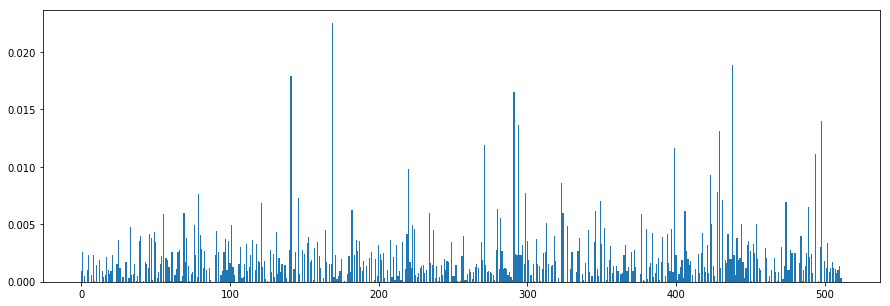

Train Epoch: 91 [0/1800 (0%)]	Loss: 8334.7998
====> Epoch: 91 Average train loss: 0.23710
====> Epoch: 91 Average test loss: 0.17806
Train Epoch: 92 [0/1800 (0%)]	Loss: 8146.2251
====> Epoch: 92 Average train loss: 0.23604
====> Epoch: 92 Average test loss: 0.17856
Train Epoch: 93 [0/1800 (0%)]	Loss: 8103.8535
====> Epoch: 93 Average train loss: 0.23651
====> Epoch: 93 Average test loss: 0.17773
Train Epoch: 94 [0/1800 (0%)]	Loss: 8679.1035
====> Epoch: 94 Average train loss: 0.23515
====> Epoch: 94 Average test loss: 0.17784
Train Epoch: 95 [0/1800 (0%)]	Loss: 8062.1758
====> Epoch: 95 Average train loss: 0.23417
====> Epoch: 95 Average test loss: 0.17726
Train Epoch: 96 [0/1800 (0%)]	Loss: 8036.4976
====> Epoch: 96 Average train loss: 0.23448
====> Epoch: 96 Average test loss: 0.17739
Train Epoch: 97 [0/1800 (0%)]	Loss: 8710.6807
====> Epoch: 97 Average train loss: 0.23423
====> Epoch: 97 Average test loss: 0.17698
Train Epoch: 98 [0/1800 (0%)]	Loss: 7924.4688
====> Epoch: 98 Average

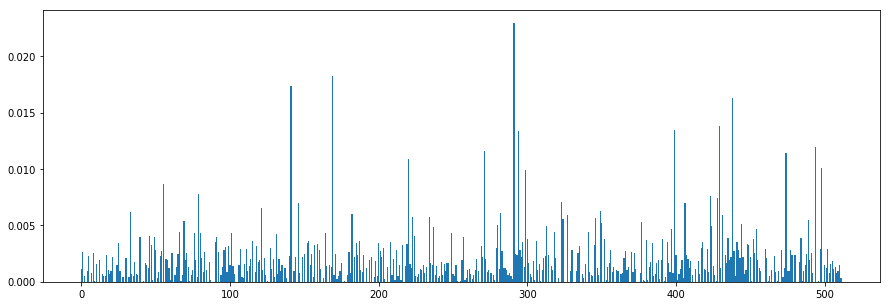

Train Epoch: 101 [0/1800 (0%)]	Loss: 8142.4897
====> Epoch: 101 Average train loss: 0.23235
====> Epoch: 101 Average test loss: 0.17609
Train Epoch: 102 [0/1800 (0%)]	Loss: 8105.1060
====> Epoch: 102 Average train loss: 0.23262
====> Epoch: 102 Average test loss: 0.17610
Train Epoch: 103 [0/1800 (0%)]	Loss: 8426.4170
====> Epoch: 103 Average train loss: 0.23142
====> Epoch: 103 Average test loss: 0.17570
Train Epoch: 104 [0/1800 (0%)]	Loss: 7862.4375
====> Epoch: 104 Average train loss: 0.23148
====> Epoch: 104 Average test loss: 0.17579
Train Epoch: 105 [0/1800 (0%)]	Loss: 8089.7715
====> Epoch: 105 Average train loss: 0.23164
====> Epoch: 105 Average test loss: 0.17525
Train Epoch: 106 [0/1800 (0%)]	Loss: 8142.9209
====> Epoch: 106 Average train loss: 0.23073
====> Epoch: 106 Average test loss: 0.17573
Train Epoch: 107 [0/1800 (0%)]	Loss: 7981.3027
====> Epoch: 107 Average train loss: 0.23134
====> Epoch: 107 Average test loss: 0.17600
Train Epoch: 108 [0/1800 (0%)]	Loss: 8282.3662
=

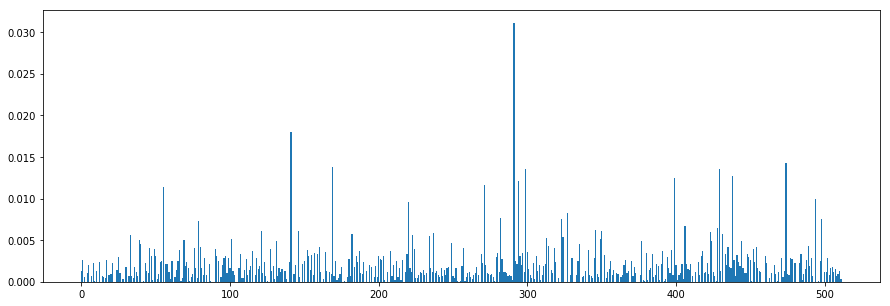

Train Epoch: 111 [0/1800 (0%)]	Loss: 7881.3066
====> Epoch: 111 Average train loss: 0.22866
====> Epoch: 111 Average test loss: 0.17478
Train Epoch: 112 [0/1800 (0%)]	Loss: 7955.8560
====> Epoch: 112 Average train loss: 0.22879
====> Epoch: 112 Average test loss: 0.17443
Train Epoch: 113 [0/1800 (0%)]	Loss: 7873.1143
====> Epoch: 113 Average train loss: 0.22841
====> Epoch: 113 Average test loss: 0.17442
Train Epoch: 114 [0/1800 (0%)]	Loss: 7315.0640
====> Epoch: 114 Average train loss: 0.22886
====> Epoch: 114 Average test loss: 0.17454
Train Epoch: 115 [0/1800 (0%)]	Loss: 8219.9199
====> Epoch: 115 Average train loss: 0.22791
====> Epoch: 115 Average test loss: 0.17374
Train Epoch: 116 [0/1800 (0%)]	Loss: 7853.3389
====> Epoch: 116 Average train loss: 0.22839
====> Epoch: 116 Average test loss: 0.17423
Train Epoch: 117 [0/1800 (0%)]	Loss: 7816.2397
====> Epoch: 117 Average train loss: 0.22731
====> Epoch: 117 Average test loss: 0.17358
Train Epoch: 118 [0/1800 (0%)]	Loss: 8265.7344
=

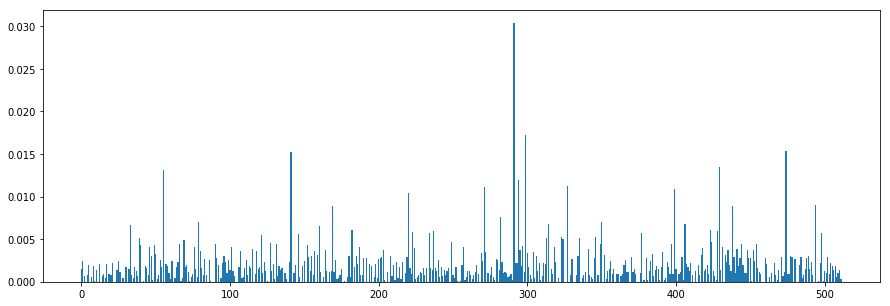

Train Epoch: 121 [0/1800 (0%)]	Loss: 8900.6875
====> Epoch: 121 Average train loss: 0.22683
====> Epoch: 121 Average test loss: 0.17313
Train Epoch: 122 [0/1800 (0%)]	Loss: 7546.0215
====> Epoch: 122 Average train loss: 0.22595
====> Epoch: 122 Average test loss: 0.17363
Train Epoch: 123 [0/1800 (0%)]	Loss: 8443.0420
====> Epoch: 123 Average train loss: 0.22675
====> Epoch: 123 Average test loss: 0.17331
Train Epoch: 124 [0/1800 (0%)]	Loss: 7832.7642
====> Epoch: 124 Average train loss: 0.22623
====> Epoch: 124 Average test loss: 0.17275
Train Epoch: 125 [0/1800 (0%)]	Loss: 8083.2153
====> Epoch: 125 Average train loss: 0.22455
====> Epoch: 125 Average test loss: 0.17250
Train Epoch: 126 [0/1800 (0%)]	Loss: 7501.2690
====> Epoch: 126 Average train loss: 0.22537
====> Epoch: 126 Average test loss: 0.17175
Train Epoch: 127 [0/1800 (0%)]	Loss: 7842.9189
====> Epoch: 127 Average train loss: 0.22544
====> Epoch: 127 Average test loss: 0.17211
Train Epoch: 128 [0/1800 (0%)]	Loss: 7673.5425
=

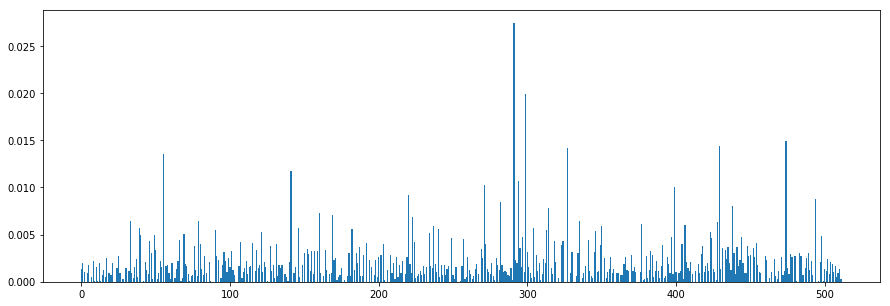

Train Epoch: 131 [0/1800 (0%)]	Loss: 8092.2236
====> Epoch: 131 Average train loss: 0.22364
====> Epoch: 131 Average test loss: 0.17217
Train Epoch: 132 [0/1800 (0%)]	Loss: 7750.9766
====> Epoch: 132 Average train loss: 0.22357
====> Epoch: 132 Average test loss: 0.17180
Train Epoch: 133 [0/1800 (0%)]	Loss: 7685.1440
====> Epoch: 133 Average train loss: 0.22305
====> Epoch: 133 Average test loss: 0.17168
Train Epoch: 134 [0/1800 (0%)]	Loss: 7886.2236
====> Epoch: 134 Average train loss: 0.22415
====> Epoch: 134 Average test loss: 0.17164
Train Epoch: 135 [0/1800 (0%)]	Loss: 7654.7217
====> Epoch: 135 Average train loss: 0.22288
====> Epoch: 135 Average test loss: 0.17161
Train Epoch: 136 [0/1800 (0%)]	Loss: 7636.0483
====> Epoch: 136 Average train loss: 0.22326
====> Epoch: 136 Average test loss: 0.17118
Train Epoch: 137 [0/1800 (0%)]	Loss: 7204.8193
====> Epoch: 137 Average train loss: 0.22198
====> Epoch: 137 Average test loss: 0.17127
Train Epoch: 138 [0/1800 (0%)]	Loss: 7767.4043
=

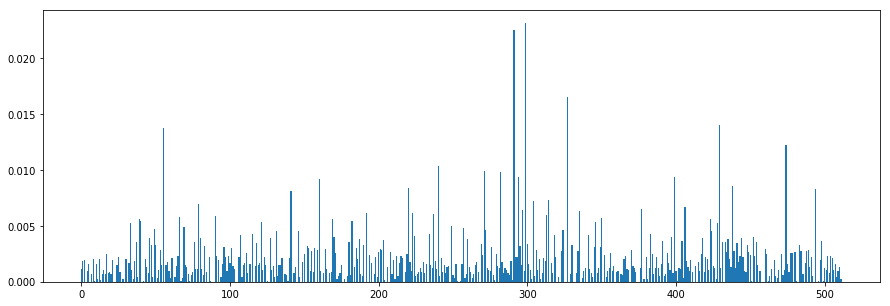

Train Epoch: 141 [0/1800 (0%)]	Loss: 7737.6880
====> Epoch: 141 Average train loss: 0.22206
====> Epoch: 141 Average test loss: 0.17047
Train Epoch: 142 [0/1800 (0%)]	Loss: 7708.3452
====> Epoch: 142 Average train loss: 0.22159
====> Epoch: 142 Average test loss: 0.17031
Train Epoch: 143 [0/1800 (0%)]	Loss: 7554.7637
====> Epoch: 143 Average train loss: 0.22114
====> Epoch: 143 Average test loss: 0.17031
Train Epoch: 144 [0/1800 (0%)]	Loss: 7463.1768
====> Epoch: 144 Average train loss: 0.22114
====> Epoch: 144 Average test loss: 0.17007
Train Epoch: 145 [0/1800 (0%)]	Loss: 7491.7627
====> Epoch: 145 Average train loss: 0.22072
====> Epoch: 145 Average test loss: 0.17012
Train Epoch: 146 [0/1800 (0%)]	Loss: 7710.5527
====> Epoch: 146 Average train loss: 0.22144
====> Epoch: 146 Average test loss: 0.17053
Train Epoch: 147 [0/1800 (0%)]	Loss: 7979.3325
====> Epoch: 147 Average train loss: 0.22090
====> Epoch: 147 Average test loss: 0.17040
Train Epoch: 148 [0/1800 (0%)]	Loss: 7166.2070
=

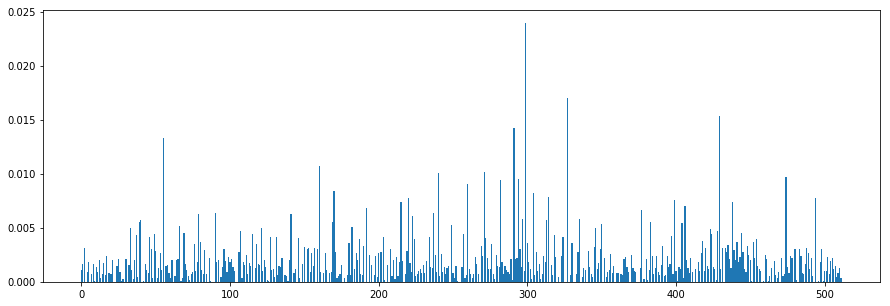

Train Epoch: 151 [0/1800 (0%)]	Loss: 7568.1436
====> Epoch: 151 Average train loss: 0.21982
====> Epoch: 151 Average test loss: 0.17008
Train Epoch: 152 [0/1800 (0%)]	Loss: 7795.8540
====> Epoch: 152 Average train loss: 0.21917
====> Epoch: 152 Average test loss: 0.16956
Train Epoch: 153 [0/1800 (0%)]	Loss: 7625.2632
====> Epoch: 153 Average train loss: 0.21895
====> Epoch: 153 Average test loss: 0.17009
Train Epoch: 154 [0/1800 (0%)]	Loss: 7223.8237
====> Epoch: 154 Average train loss: 0.21943
====> Epoch: 154 Average test loss: 0.16955
Train Epoch: 155 [0/1800 (0%)]	Loss: 7826.5825
====> Epoch: 155 Average train loss: 0.21858
====> Epoch: 155 Average test loss: 0.16895
Train Epoch: 156 [0/1800 (0%)]	Loss: 7581.9692
====> Epoch: 156 Average train loss: 0.21936
====> Epoch: 156 Average test loss: 0.16958
Train Epoch: 157 [0/1800 (0%)]	Loss: 7934.0532
====> Epoch: 157 Average train loss: 0.21823
====> Epoch: 157 Average test loss: 0.16935
Train Epoch: 158 [0/1800 (0%)]	Loss: 7425.2656
=

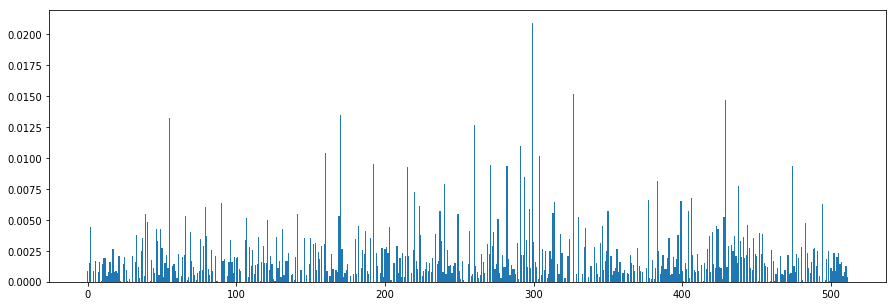

Train Epoch: 161 [0/1800 (0%)]	Loss: 7490.8735
====> Epoch: 161 Average train loss: 0.21806
====> Epoch: 161 Average test loss: 0.16894
Train Epoch: 162 [0/1800 (0%)]	Loss: 7448.0874
====> Epoch: 162 Average train loss: 0.21847
====> Epoch: 162 Average test loss: 0.16880
Train Epoch: 163 [0/1800 (0%)]	Loss: 7527.0283
====> Epoch: 163 Average train loss: 0.21761
====> Epoch: 163 Average test loss: 0.16877
Train Epoch: 164 [0/1800 (0%)]	Loss: 7668.3804
====> Epoch: 164 Average train loss: 0.21683
====> Epoch: 164 Average test loss: 0.16865
Train Epoch: 165 [0/1800 (0%)]	Loss: 7511.4204
====> Epoch: 165 Average train loss: 0.21633
====> Epoch: 165 Average test loss: 0.16887
Train Epoch: 166 [0/1800 (0%)]	Loss: 7202.7344
====> Epoch: 166 Average train loss: 0.21751
====> Epoch: 166 Average test loss: 0.16848
Train Epoch: 167 [0/1800 (0%)]	Loss: 7683.3398
====> Epoch: 167 Average train loss: 0.21699
====> Epoch: 167 Average test loss: 0.16845
Train Epoch: 168 [0/1800 (0%)]	Loss: 7516.3364
=

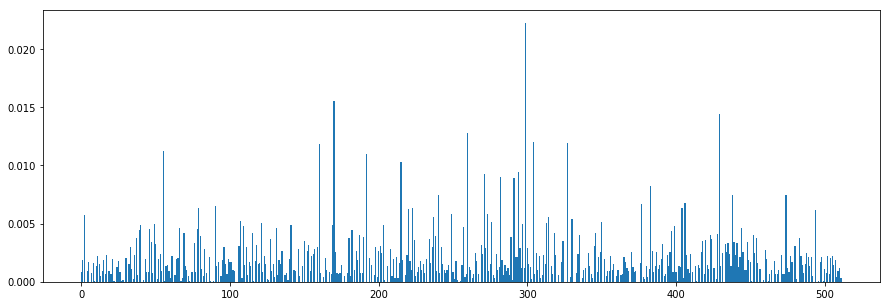

Train Epoch: 171 [0/1800 (0%)]	Loss: 7292.6914
====> Epoch: 171 Average train loss: 0.21587
====> Epoch: 171 Average test loss: 0.16827
Train Epoch: 172 [0/1800 (0%)]	Loss: 7545.3555
====> Epoch: 172 Average train loss: 0.21618
====> Epoch: 172 Average test loss: 0.16763
Train Epoch: 173 [0/1800 (0%)]	Loss: 7742.2197
====> Epoch: 173 Average train loss: 0.21521
====> Epoch: 173 Average test loss: 0.16741
Train Epoch: 174 [0/1800 (0%)]	Loss: 7313.8193
====> Epoch: 174 Average train loss: 0.21604
====> Epoch: 174 Average test loss: 0.16789
Train Epoch: 175 [0/1800 (0%)]	Loss: 7328.3721
====> Epoch: 175 Average train loss: 0.21599
====> Epoch: 175 Average test loss: 0.16784
Train Epoch: 176 [0/1800 (0%)]	Loss: 7210.2837
====> Epoch: 176 Average train loss: 0.21537
====> Epoch: 176 Average test loss: 0.16788
Train Epoch: 177 [0/1800 (0%)]	Loss: 7413.2744
====> Epoch: 177 Average train loss: 0.21570
====> Epoch: 177 Average test loss: 0.16755
Train Epoch: 178 [0/1800 (0%)]	Loss: 8039.4648
=

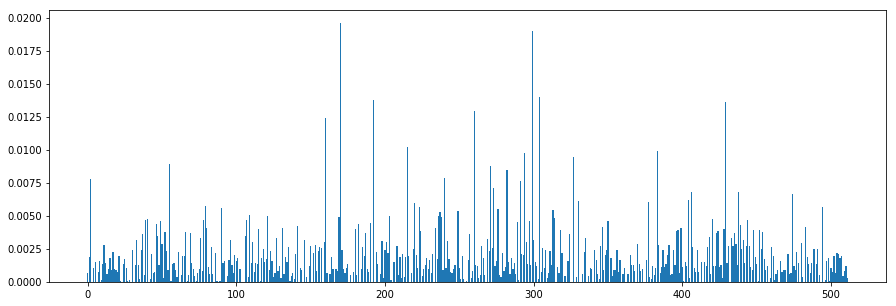

Train Epoch: 181 [0/1800 (0%)]	Loss: 7744.1777
====> Epoch: 181 Average train loss: 0.21419
====> Epoch: 181 Average test loss: 0.16755
Train Epoch: 182 [0/1800 (0%)]	Loss: 7721.4331
====> Epoch: 182 Average train loss: 0.21484
====> Epoch: 182 Average test loss: 0.16729
Train Epoch: 183 [0/1800 (0%)]	Loss: 7705.5371
====> Epoch: 183 Average train loss: 0.21468
====> Epoch: 183 Average test loss: 0.16715
Train Epoch: 184 [0/1800 (0%)]	Loss: 7228.4233
====> Epoch: 184 Average train loss: 0.21444
====> Epoch: 184 Average test loss: 0.16686
Train Epoch: 185 [0/1800 (0%)]	Loss: 6976.8286
====> Epoch: 185 Average train loss: 0.21460
====> Epoch: 185 Average test loss: 0.16740
Train Epoch: 186 [0/1800 (0%)]	Loss: 7223.8799
====> Epoch: 186 Average train loss: 0.21447
====> Epoch: 186 Average test loss: 0.16710
Train Epoch: 187 [0/1800 (0%)]	Loss: 7123.9863
====> Epoch: 187 Average train loss: 0.21402
====> Epoch: 187 Average test loss: 0.16764
Train Epoch: 188 [0/1800 (0%)]	Loss: 7265.0537
=

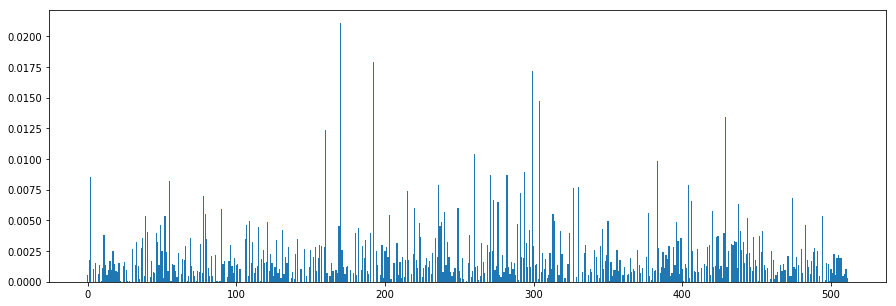

Train Epoch: 191 [0/1800 (0%)]	Loss: 6904.7910
====> Epoch: 191 Average train loss: 0.21329
====> Epoch: 191 Average test loss: 0.16712
Train Epoch: 192 [0/1800 (0%)]	Loss: 7220.1890
====> Epoch: 192 Average train loss: 0.21315
====> Epoch: 192 Average test loss: 0.16701
Train Epoch: 193 [0/1800 (0%)]	Loss: 7200.3701
====> Epoch: 193 Average train loss: 0.21335
====> Epoch: 193 Average test loss: 0.16691
Train Epoch: 194 [0/1800 (0%)]	Loss: 7550.7642
====> Epoch: 194 Average train loss: 0.21294
====> Epoch: 194 Average test loss: 0.16694
Train Epoch: 195 [0/1800 (0%)]	Loss: 7765.5371
====> Epoch: 195 Average train loss: 0.21290
====> Epoch: 195 Average test loss: 0.16654
Train Epoch: 196 [0/1800 (0%)]	Loss: 7188.9375
====> Epoch: 196 Average train loss: 0.21262
====> Epoch: 196 Average test loss: 0.16660
Train Epoch: 197 [0/1800 (0%)]	Loss: 7271.0332
====> Epoch: 197 Average train loss: 0.21265
====> Epoch: 197 Average test loss: 0.16649
Train Epoch: 198 [0/1800 (0%)]	Loss: 7357.6743
=

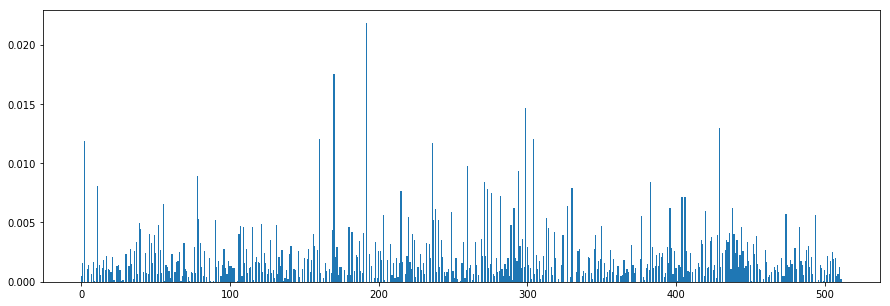

Train Epoch: 201 [0/1800 (0%)]	Loss: 7690.7305
====> Epoch: 201 Average train loss: 0.21233
====> Epoch: 201 Average test loss: 0.16650
Train Epoch: 202 [0/1800 (0%)]	Loss: 8157.1343
====> Epoch: 202 Average train loss: 0.21240
====> Epoch: 202 Average test loss: 0.16644
Train Epoch: 203 [0/1800 (0%)]	Loss: 7433.5073
====> Epoch: 203 Average train loss: 0.21229
====> Epoch: 203 Average test loss: 0.16650
Train Epoch: 204 [0/1800 (0%)]	Loss: 7239.0166
====> Epoch: 204 Average train loss: 0.21182
====> Epoch: 204 Average test loss: 0.16641
Train Epoch: 205 [0/1800 (0%)]	Loss: 7210.8818
====> Epoch: 205 Average train loss: 0.21159
====> Epoch: 205 Average test loss: 0.16659
Train Epoch: 206 [0/1800 (0%)]	Loss: 6916.0381
====> Epoch: 206 Average train loss: 0.21156
====> Epoch: 206 Average test loss: 0.16630
Train Epoch: 207 [0/1800 (0%)]	Loss: 7837.0952
====> Epoch: 207 Average train loss: 0.21123
====> Epoch: 207 Average test loss: 0.16611
Train Epoch: 208 [0/1800 (0%)]	Loss: 6811.4141
=

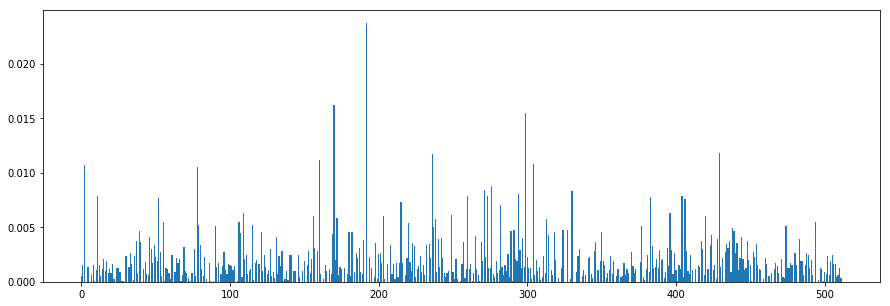

Train Epoch: 211 [0/1800 (0%)]	Loss: 7332.7505
====> Epoch: 211 Average train loss: 0.21149
====> Epoch: 211 Average test loss: 0.16616
Train Epoch: 212 [0/1800 (0%)]	Loss: 6793.8521
====> Epoch: 212 Average train loss: 0.21038
====> Epoch: 212 Average test loss: 0.16557
Train Epoch: 213 [0/1800 (0%)]	Loss: 7471.8247
====> Epoch: 213 Average train loss: 0.21071
====> Epoch: 213 Average test loss: 0.16558
Train Epoch: 214 [0/1800 (0%)]	Loss: 7195.1973
====> Epoch: 214 Average train loss: 0.21014
====> Epoch: 214 Average test loss: 0.16574
Train Epoch: 215 [0/1800 (0%)]	Loss: 7009.8682
====> Epoch: 215 Average train loss: 0.21045
====> Epoch: 215 Average test loss: 0.16540
Train Epoch: 216 [0/1800 (0%)]	Loss: 7240.4023
====> Epoch: 216 Average train loss: 0.21006
====> Epoch: 216 Average test loss: 0.16549
Train Epoch: 217 [0/1800 (0%)]	Loss: 7120.2676
====> Epoch: 217 Average train loss: 0.21028
====> Epoch: 217 Average test loss: 0.16520
Train Epoch: 218 [0/1800 (0%)]	Loss: 7289.4414
=

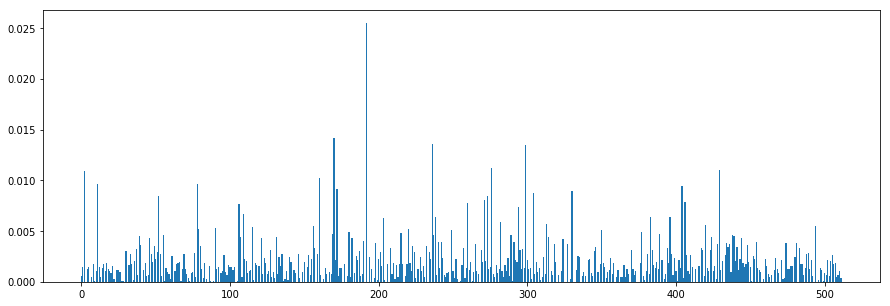

Train Epoch: 221 [0/1800 (0%)]	Loss: 7209.2803
====> Epoch: 221 Average train loss: 0.21004
====> Epoch: 221 Average test loss: 0.16537
Train Epoch: 222 [0/1800 (0%)]	Loss: 7433.1069
====> Epoch: 222 Average train loss: 0.21020
====> Epoch: 222 Average test loss: 0.16536
Train Epoch: 223 [0/1800 (0%)]	Loss: 7402.8579
====> Epoch: 223 Average train loss: 0.20994
====> Epoch: 223 Average test loss: 0.16532
Train Epoch: 224 [0/1800 (0%)]	Loss: 7306.2134
====> Epoch: 224 Average train loss: 0.20931
====> Epoch: 224 Average test loss: 0.16504
Train Epoch: 225 [0/1800 (0%)]	Loss: 7224.4199
====> Epoch: 225 Average train loss: 0.20932
====> Epoch: 225 Average test loss: 0.16533
Train Epoch: 226 [0/1800 (0%)]	Loss: 7527.1797
====> Epoch: 226 Average train loss: 0.20914
====> Epoch: 226 Average test loss: 0.16507
Train Epoch: 227 [0/1800 (0%)]	Loss: 7478.9136
====> Epoch: 227 Average train loss: 0.20986
====> Epoch: 227 Average test loss: 0.16532
Train Epoch: 228 [0/1800 (0%)]	Loss: 7411.1704
=

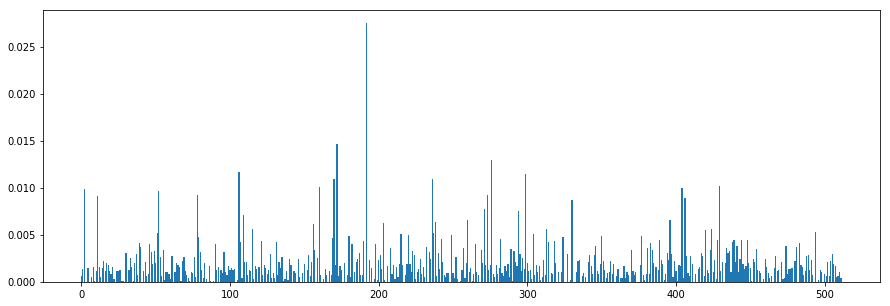

Train Epoch: 231 [0/1800 (0%)]	Loss: 7183.1885
====> Epoch: 231 Average train loss: 0.20958
====> Epoch: 231 Average test loss: 0.16528
Train Epoch: 232 [0/1800 (0%)]	Loss: 6923.1089
====> Epoch: 232 Average train loss: 0.20923
====> Epoch: 232 Average test loss: 0.16539
Train Epoch: 233 [0/1800 (0%)]	Loss: 7046.1719
====> Epoch: 233 Average train loss: 0.20957
====> Epoch: 233 Average test loss: 0.16547
Train Epoch: 234 [0/1800 (0%)]	Loss: 6823.0181
====> Epoch: 234 Average train loss: 0.20878
====> Epoch: 234 Average test loss: 0.16528
Train Epoch: 235 [0/1800 (0%)]	Loss: 7116.4268
====> Epoch: 235 Average train loss: 0.20887
====> Epoch: 235 Average test loss: 0.16530
Train Epoch: 236 [0/1800 (0%)]	Loss: 7129.9922
====> Epoch: 236 Average train loss: 0.20873
====> Epoch: 236 Average test loss: 0.16545
Train Epoch: 237 [0/1800 (0%)]	Loss: 7532.2197
====> Epoch: 237 Average train loss: 0.20886
====> Epoch: 237 Average test loss: 0.16515
Train Epoch: 238 [0/1800 (0%)]	Loss: 7127.9868
=

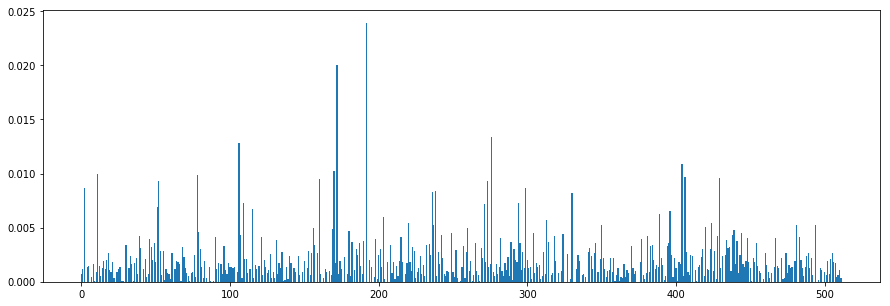

Train Epoch: 241 [0/1800 (0%)]	Loss: 6829.1704
====> Epoch: 241 Average train loss: 0.20814
====> Epoch: 241 Average test loss: 0.16448
Train Epoch: 242 [0/1800 (0%)]	Loss: 6910.8638
====> Epoch: 242 Average train loss: 0.20834
====> Epoch: 242 Average test loss: 0.16478
Train Epoch: 243 [0/1800 (0%)]	Loss: 7037.8716
====> Epoch: 243 Average train loss: 0.20825
====> Epoch: 243 Average test loss: 0.16459
Train Epoch: 244 [0/1800 (0%)]	Loss: 6683.8853
====> Epoch: 244 Average train loss: 0.20757
====> Epoch: 244 Average test loss: 0.16461
Train Epoch: 245 [0/1800 (0%)]	Loss: 7474.8320
====> Epoch: 245 Average train loss: 0.20755
====> Epoch: 245 Average test loss: 0.16495
Train Epoch: 246 [0/1800 (0%)]	Loss: 6939.9282
====> Epoch: 246 Average train loss: 0.20824
====> Epoch: 246 Average test loss: 0.16452
Train Epoch: 247 [0/1800 (0%)]	Loss: 7169.5928
====> Epoch: 247 Average train loss: 0.20762
====> Epoch: 247 Average test loss: 0.16458
Train Epoch: 248 [0/1800 (0%)]	Loss: 7274.7158
=

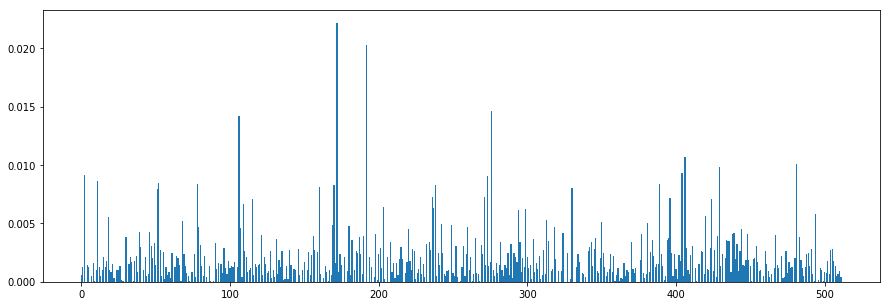

Train Epoch: 251 [0/1800 (0%)]	Loss: 7248.0132
====> Epoch: 251 Average train loss: 0.20703
====> Epoch: 251 Average test loss: 0.16423
Train Epoch: 252 [0/1800 (0%)]	Loss: 7553.6338
====> Epoch: 252 Average train loss: 0.20680
====> Epoch: 252 Average test loss: 0.16415
Train Epoch: 253 [0/1800 (0%)]	Loss: 6948.9956
====> Epoch: 253 Average train loss: 0.20687
====> Epoch: 253 Average test loss: 0.16404
Train Epoch: 254 [0/1800 (0%)]	Loss: 7703.5347
====> Epoch: 254 Average train loss: 0.20674
====> Epoch: 254 Average test loss: 0.16408
Train Epoch: 255 [0/1800 (0%)]	Loss: 6995.6733
====> Epoch: 255 Average train loss: 0.20677
====> Epoch: 255 Average test loss: 0.16418
Train Epoch: 256 [0/1800 (0%)]	Loss: 7222.3984
====> Epoch: 256 Average train loss: 0.20671
====> Epoch: 256 Average test loss: 0.16411
Train Epoch: 257 [0/1800 (0%)]	Loss: 7222.9395
====> Epoch: 257 Average train loss: 0.20665
====> Epoch: 257 Average test loss: 0.16401
Train Epoch: 258 [0/1800 (0%)]	Loss: 7041.6860
=

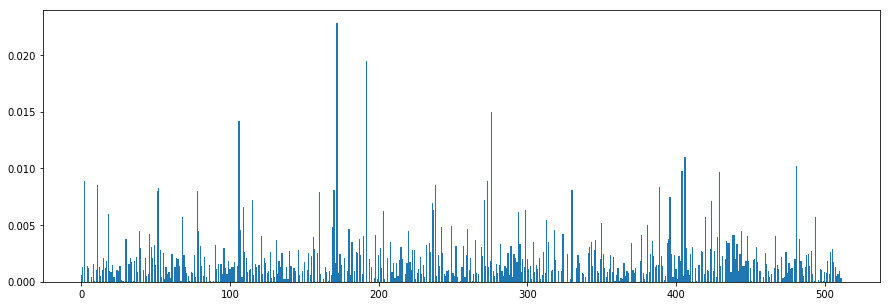

Train Epoch: 261 [0/1800 (0%)]	Loss: 6918.1157
====> Epoch: 261 Average train loss: 0.20645
====> Epoch: 261 Average test loss: 0.16389
Train Epoch: 262 [0/1800 (0%)]	Loss: 7260.3730
====> Epoch: 262 Average train loss: 0.20612
====> Epoch: 262 Average test loss: 0.16401
Train Epoch: 263 [0/1800 (0%)]	Loss: 7041.2808
====> Epoch: 263 Average train loss: 0.20666
====> Epoch: 263 Average test loss: 0.16396
Train Epoch: 264 [0/1800 (0%)]	Loss: 6982.3237
====> Epoch: 264 Average train loss: 0.20639
====> Epoch: 264 Average test loss: 0.16414
Train Epoch: 265 [0/1800 (0%)]	Loss: 7037.3770
====> Epoch: 265 Average train loss: 0.20640
====> Epoch: 265 Average test loss: 0.16402
Train Epoch: 266 [0/1800 (0%)]	Loss: 7067.2871
====> Epoch: 266 Average train loss: 0.20656
====> Epoch: 266 Average test loss: 0.16398
Train Epoch: 267 [0/1800 (0%)]	Loss: 7070.9849
====> Epoch: 267 Average train loss: 0.20651
====> Epoch: 267 Average test loss: 0.16410
Train Epoch: 268 [0/1800 (0%)]	Loss: 7064.1187
=

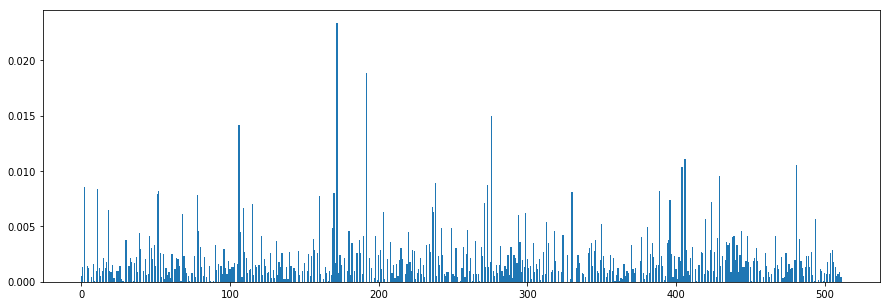

Train Epoch: 271 [0/1800 (0%)]	Loss: 6612.4712
====> Epoch: 271 Average train loss: 0.20641
====> Epoch: 271 Average test loss: 0.16394
Train Epoch: 272 [0/1800 (0%)]	Loss: 6999.4390
====> Epoch: 272 Average train loss: 0.20626
====> Epoch: 272 Average test loss: 0.16397
Train Epoch: 273 [0/1800 (0%)]	Loss: 7036.8550
====> Epoch: 273 Average train loss: 0.20643
====> Epoch: 273 Average test loss: 0.16396
Train Epoch: 274 [0/1800 (0%)]	Loss: 7165.3838
====> Epoch: 274 Average train loss: 0.20653
====> Epoch: 274 Average test loss: 0.16392
Train Epoch: 275 [0/1800 (0%)]	Loss: 6974.6406
====> Epoch: 275 Average train loss: 0.20622
====> Epoch: 275 Average test loss: 0.16397
Train Epoch: 276 [0/1800 (0%)]	Loss: 7236.0352
====> Epoch: 276 Average train loss: 0.20600
====> Epoch: 276 Average test loss: 0.16389
Train Epoch: 277 [0/1800 (0%)]	Loss: 7644.0972
====> Epoch: 277 Average train loss: 0.20628
====> Epoch: 277 Average test loss: 0.16404
Train Epoch: 278 [0/1800 (0%)]	Loss: 7259.7393
=

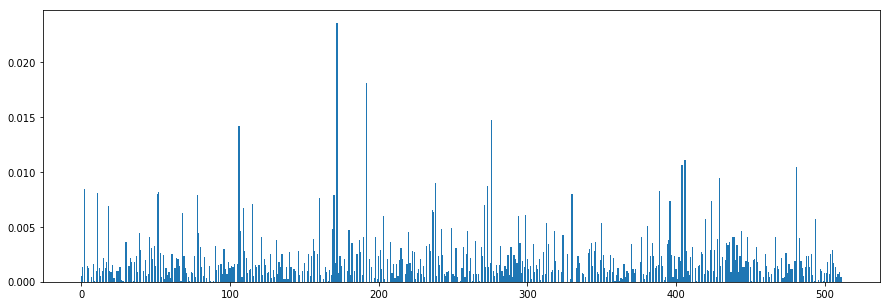

Train Epoch: 281 [0/1800 (0%)]	Loss: 6647.1982
====> Epoch: 281 Average train loss: 0.20646
====> Epoch: 281 Average test loss: 0.16394
Train Epoch: 282 [0/1800 (0%)]	Loss: 6790.8906
====> Epoch: 282 Average train loss: 0.20654
====> Epoch: 282 Average test loss: 0.16389
Train Epoch: 283 [0/1800 (0%)]	Loss: 7694.3447
====> Epoch: 283 Average train loss: 0.20592
====> Epoch: 283 Average test loss: 0.16406
Train Epoch: 284 [0/1800 (0%)]	Loss: 7462.5298
====> Epoch: 284 Average train loss: 0.20585
====> Epoch: 284 Average test loss: 0.16387
Train Epoch: 285 [0/1800 (0%)]	Loss: 7082.5967
====> Epoch: 285 Average train loss: 0.20566
====> Epoch: 285 Average test loss: 0.16401
Train Epoch: 286 [0/1800 (0%)]	Loss: 7116.1445
====> Epoch: 286 Average train loss: 0.20590
====> Epoch: 286 Average test loss: 0.16390
Train Epoch: 287 [0/1800 (0%)]	Loss: 7685.6558
====> Epoch: 287 Average train loss: 0.20602
====> Epoch: 287 Average test loss: 0.16385
Train Epoch: 288 [0/1800 (0%)]	Loss: 6946.5732
=

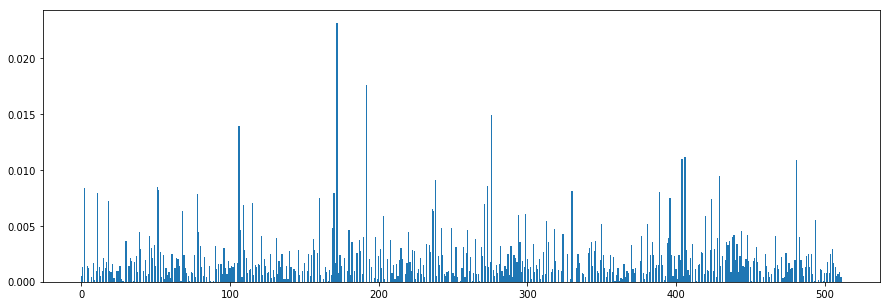

Train Epoch: 291 [0/1800 (0%)]	Loss: 8207.5127
====> Epoch: 291 Average train loss: 0.20656
====> Epoch: 291 Average test loss: 0.16379
Train Epoch: 292 [0/1800 (0%)]	Loss: 7171.8184
====> Epoch: 292 Average train loss: 0.20626
====> Epoch: 292 Average test loss: 0.16387
Train Epoch: 293 [0/1800 (0%)]	Loss: 6969.9722
====> Epoch: 293 Average train loss: 0.20552
====> Epoch: 293 Average test loss: 0.16384
Train Epoch: 294 [0/1800 (0%)]	Loss: 6902.1895
====> Epoch: 294 Average train loss: 0.20595
====> Epoch: 294 Average test loss: 0.16395
Train Epoch: 295 [0/1800 (0%)]	Loss: 7102.8809
====> Epoch: 295 Average train loss: 0.20617
====> Epoch: 295 Average test loss: 0.16389
Train Epoch: 296 [0/1800 (0%)]	Loss: 7288.8408
====> Epoch: 296 Average train loss: 0.20654
====> Epoch: 296 Average test loss: 0.16400
Train Epoch: 297 [0/1800 (0%)]	Loss: 7295.4795
====> Epoch: 297 Average train loss: 0.20629
====> Epoch: 297 Average test loss: 0.16379
Train Epoch: 298 [0/1800 (0%)]	Loss: 7092.9619
=

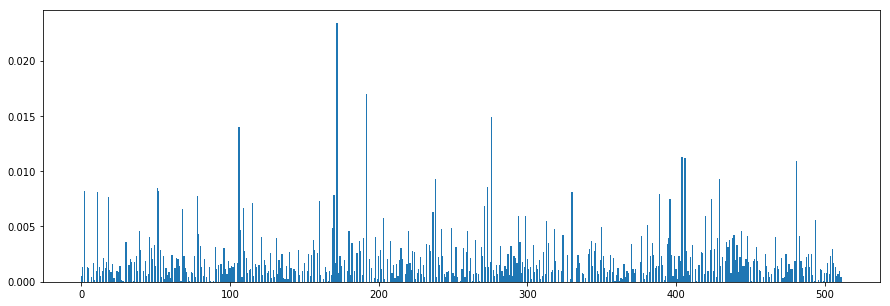

Train Epoch: 301 [0/1800 (0%)]	Loss: 7116.1636
====> Epoch: 301 Average train loss: 0.20612
====> Epoch: 301 Average test loss: 0.16382
Train Epoch: 302 [0/1800 (0%)]	Loss: 7001.9897
====> Epoch: 302 Average train loss: 0.20557
====> Epoch: 302 Average test loss: 0.16372
Train Epoch: 303 [0/1800 (0%)]	Loss: 7025.0347
====> Epoch: 303 Average train loss: 0.20634
====> Epoch: 303 Average test loss: 0.16383
Train Epoch: 304 [0/1800 (0%)]	Loss: 6972.5815
====> Epoch: 304 Average train loss: 0.20617
====> Epoch: 304 Average test loss: 0.16379
Train Epoch: 305 [0/1800 (0%)]	Loss: 7133.4092
====> Epoch: 305 Average train loss: 0.20634
====> Epoch: 305 Average test loss: 0.16383
Train Epoch: 306 [0/1800 (0%)]	Loss: 7093.9546
====> Epoch: 306 Average train loss: 0.20545
====> Epoch: 306 Average test loss: 0.16383
Train Epoch: 307 [0/1800 (0%)]	Loss: 7370.7983
====> Epoch: 307 Average train loss: 0.20646
====> Epoch: 307 Average test loss: 0.16391
Train Epoch: 308 [0/1800 (0%)]	Loss: 7075.7822
=

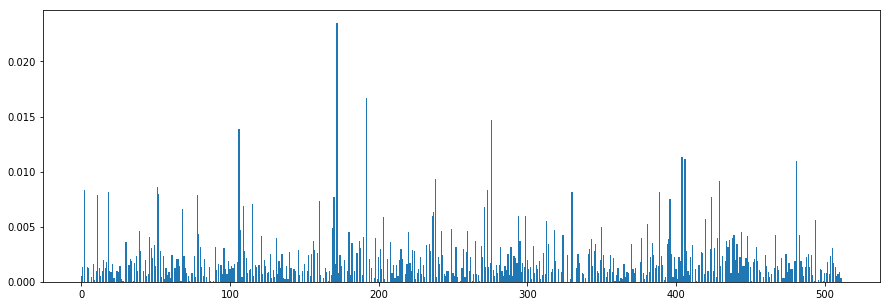

Train Epoch: 311 [0/1800 (0%)]	Loss: 7317.9268
====> Epoch: 311 Average train loss: 0.20617
====> Epoch: 311 Average test loss: 0.16384
Train Epoch: 312 [0/1800 (0%)]	Loss: 6984.2236
====> Epoch: 312 Average train loss: 0.20629
====> Epoch: 312 Average test loss: 0.16388
Train Epoch: 313 [0/1800 (0%)]	Loss: 6891.8608
====> Epoch: 313 Average train loss: 0.20613
====> Epoch: 313 Average test loss: 0.16386
Train Epoch: 314 [0/1800 (0%)]	Loss: 7195.4751
====> Epoch: 314 Average train loss: 0.20617
====> Epoch: 314 Average test loss: 0.16381
Train Epoch: 315 [0/1800 (0%)]	Loss: 7416.0474
====> Epoch: 315 Average train loss: 0.20555
====> Epoch: 315 Average test loss: 0.16378
Train Epoch: 316 [0/1800 (0%)]	Loss: 6951.7671
====> Epoch: 316 Average train loss: 0.20616
====> Epoch: 316 Average test loss: 0.16376
Train Epoch: 317 [0/1800 (0%)]	Loss: 7394.3691
====> Epoch: 317 Average train loss: 0.20587
====> Epoch: 317 Average test loss: 0.16383
Train Epoch: 318 [0/1800 (0%)]	Loss: 7391.9976
=

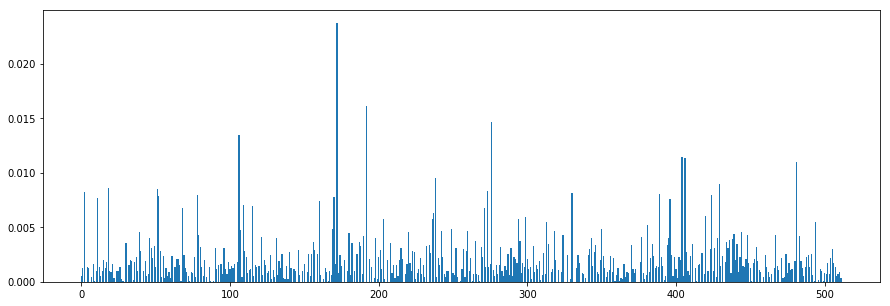

Train Epoch: 321 [0/1800 (0%)]	Loss: 6807.7573
====> Epoch: 321 Average train loss: 0.20538
====> Epoch: 321 Average test loss: 0.16382
Train Epoch: 322 [0/1800 (0%)]	Loss: 6772.8999
====> Epoch: 322 Average train loss: 0.20545
====> Epoch: 322 Average test loss: 0.16383
Train Epoch: 323 [0/1800 (0%)]	Loss: 6926.8262
====> Epoch: 323 Average train loss: 0.20634
====> Epoch: 323 Average test loss: 0.16373
Train Epoch: 324 [0/1800 (0%)]	Loss: 7139.0571
====> Epoch: 324 Average train loss: 0.20522
====> Epoch: 324 Average test loss: 0.16372
Train Epoch: 325 [0/1800 (0%)]	Loss: 6644.2534
====> Epoch: 325 Average train loss: 0.20579
====> Epoch: 325 Average test loss: 0.16371
Train Epoch: 326 [0/1800 (0%)]	Loss: 6757.2046
====> Epoch: 326 Average train loss: 0.20634
====> Epoch: 326 Average test loss: 0.16391
Train Epoch: 327 [0/1800 (0%)]	Loss: 7277.8633
====> Epoch: 327 Average train loss: 0.20614
====> Epoch: 327 Average test loss: 0.16382
Train Epoch: 328 [0/1800 (0%)]	Loss: 6928.0527
=

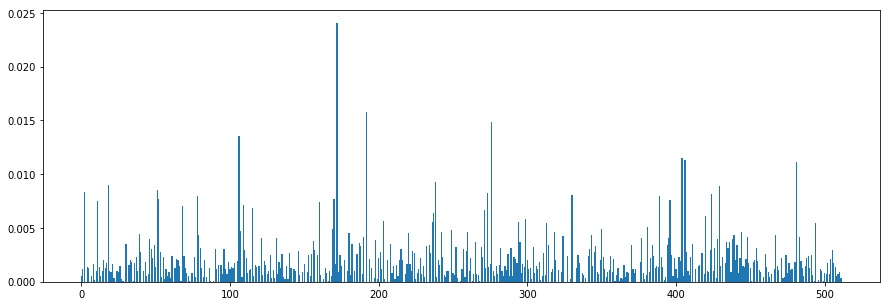

Train Epoch: 331 [0/1800 (0%)]	Loss: 7202.9775
====> Epoch: 331 Average train loss: 0.20540
====> Epoch: 331 Average test loss: 0.16371
Train Epoch: 332 [0/1800 (0%)]	Loss: 6992.2310
====> Epoch: 332 Average train loss: 0.20614
====> Epoch: 332 Average test loss: 0.16372
Train Epoch: 333 [0/1800 (0%)]	Loss: 7308.4614
====> Epoch: 333 Average train loss: 0.20603
====> Epoch: 333 Average test loss: 0.16384
Train Epoch: 334 [0/1800 (0%)]	Loss: 7014.1768
====> Epoch: 334 Average train loss: 0.20570
====> Epoch: 334 Average test loss: 0.16369
Train Epoch: 335 [0/1800 (0%)]	Loss: 7354.7031
====> Epoch: 335 Average train loss: 0.20623
====> Epoch: 335 Average test loss: 0.16365
Train Epoch: 336 [0/1800 (0%)]	Loss: 6669.7896
====> Epoch: 336 Average train loss: 0.20629
====> Epoch: 336 Average test loss: 0.16366
Train Epoch: 337 [0/1800 (0%)]	Loss: 6671.0908
====> Epoch: 337 Average train loss: 0.20609
====> Epoch: 337 Average test loss: 0.16355
Train Epoch: 338 [0/1800 (0%)]	Loss: 6969.5181
=

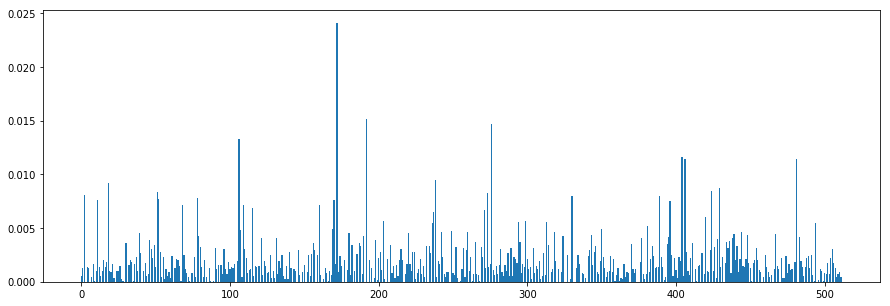

Train Epoch: 341 [0/1800 (0%)]	Loss: 6989.2764
====> Epoch: 341 Average train loss: 0.20568
====> Epoch: 341 Average test loss: 0.16378
Train Epoch: 342 [0/1800 (0%)]	Loss: 7211.7876
====> Epoch: 342 Average train loss: 0.20563
====> Epoch: 342 Average test loss: 0.16356
Train Epoch: 343 [0/1800 (0%)]	Loss: 6963.0591
====> Epoch: 343 Average train loss: 0.20533
====> Epoch: 343 Average test loss: 0.16370
Train Epoch: 344 [0/1800 (0%)]	Loss: 6957.5010
====> Epoch: 344 Average train loss: 0.20514
====> Epoch: 344 Average test loss: 0.16358
Train Epoch: 345 [0/1800 (0%)]	Loss: 6855.7314
====> Epoch: 345 Average train loss: 0.20531
====> Epoch: 345 Average test loss: 0.16370
Train Epoch: 346 [0/1800 (0%)]	Loss: 7046.1611
====> Epoch: 346 Average train loss: 0.20668
====> Epoch: 346 Average test loss: 0.16381
Train Epoch: 347 [0/1800 (0%)]	Loss: 6912.3354
====> Epoch: 347 Average train loss: 0.20538
====> Epoch: 347 Average test loss: 0.16375
Train Epoch: 348 [0/1800 (0%)]	Loss: 7172.6587
=

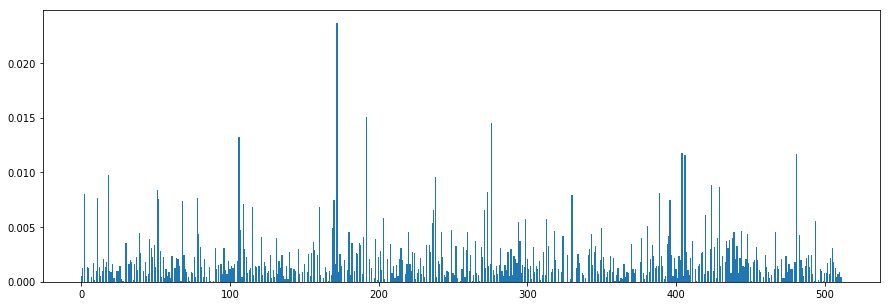

Train Epoch: 351 [0/1800 (0%)]	Loss: 6999.8931
====> Epoch: 351 Average train loss: 0.20534
====> Epoch: 351 Average test loss: 0.16369
Train Epoch: 352 [0/1800 (0%)]	Loss: 7602.6123
====> Epoch: 352 Average train loss: 0.20487
====> Epoch: 352 Average test loss: 0.16368
Train Epoch: 353 [0/1800 (0%)]	Loss: 6759.1211
====> Epoch: 353 Average train loss: 0.20568
====> Epoch: 353 Average test loss: 0.16388
Train Epoch: 354 [0/1800 (0%)]	Loss: 7494.9229
====> Epoch: 354 Average train loss: 0.20525
====> Epoch: 354 Average test loss: 0.16361
Train Epoch: 355 [0/1800 (0%)]	Loss: 7076.2793
====> Epoch: 355 Average train loss: 0.20570
====> Epoch: 355 Average test loss: 0.16373
Train Epoch: 356 [0/1800 (0%)]	Loss: 7176.3682
====> Epoch: 356 Average train loss: 0.20611
====> Epoch: 356 Average test loss: 0.16370
Train Epoch: 357 [0/1800 (0%)]	Loss: 6851.4580
====> Epoch: 357 Average train loss: 0.20566
====> Epoch: 357 Average test loss: 0.16353
Train Epoch: 358 [0/1800 (0%)]	Loss: 7092.9873
=

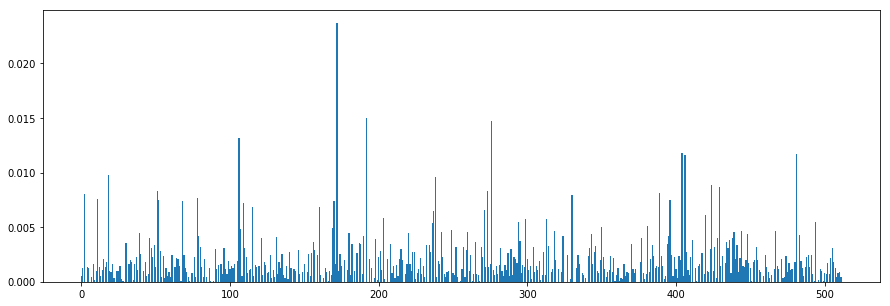

Train Epoch: 361 [0/1800 (0%)]	Loss: 6739.2979
====> Epoch: 361 Average train loss: 0.20509
====> Epoch: 361 Average test loss: 0.16368
Train Epoch: 362 [0/1800 (0%)]	Loss: 6855.3677
====> Epoch: 362 Average train loss: 0.20486
====> Epoch: 362 Average test loss: 0.16358
Train Epoch: 363 [0/1800 (0%)]	Loss: 6899.3564
====> Epoch: 363 Average train loss: 0.20513
====> Epoch: 363 Average test loss: 0.16376
Train Epoch: 364 [0/1800 (0%)]	Loss: 7626.7925
====> Epoch: 364 Average train loss: 0.20541
====> Epoch: 364 Average test loss: 0.16373
Train Epoch: 365 [0/1800 (0%)]	Loss: 7232.3594
====> Epoch: 365 Average train loss: 0.20595
====> Epoch: 365 Average test loss: 0.16369
Train Epoch: 366 [0/1800 (0%)]	Loss: 7165.7915
====> Epoch: 366 Average train loss: 0.20593
====> Epoch: 366 Average test loss: 0.16372
Train Epoch: 367 [0/1800 (0%)]	Loss: 6949.9541
====> Epoch: 367 Average train loss: 0.20584
====> Epoch: 367 Average test loss: 0.16371
Train Epoch: 368 [0/1800 (0%)]	Loss: 6938.6128
=

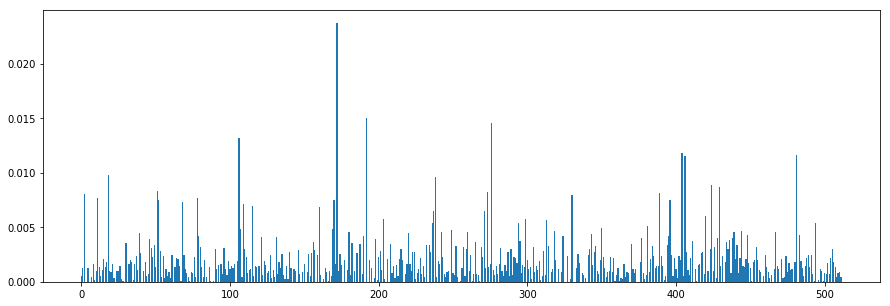

Train Epoch: 371 [0/1800 (0%)]	Loss: 7042.5083
====> Epoch: 371 Average train loss: 0.20546
====> Epoch: 371 Average test loss: 0.16358
Train Epoch: 372 [0/1800 (0%)]	Loss: 6776.4790
====> Epoch: 372 Average train loss: 0.20544
====> Epoch: 372 Average test loss: 0.16365
Train Epoch: 373 [0/1800 (0%)]	Loss: 7303.9434
====> Epoch: 373 Average train loss: 0.20628
====> Epoch: 373 Average test loss: 0.16365
Train Epoch: 374 [0/1800 (0%)]	Loss: 7106.6641
====> Epoch: 374 Average train loss: 0.20526
====> Epoch: 374 Average test loss: 0.16363
Train Epoch: 375 [0/1800 (0%)]	Loss: 7140.1680
====> Epoch: 375 Average train loss: 0.20559
====> Epoch: 375 Average test loss: 0.16354
Train Epoch: 376 [0/1800 (0%)]	Loss: 7439.3276
====> Epoch: 376 Average train loss: 0.20522
====> Epoch: 376 Average test loss: 0.16363
Train Epoch: 377 [0/1800 (0%)]	Loss: 7139.9717
====> Epoch: 377 Average train loss: 0.20541
====> Epoch: 377 Average test loss: 0.16375
Train Epoch: 378 [0/1800 (0%)]	Loss: 7026.2715
=

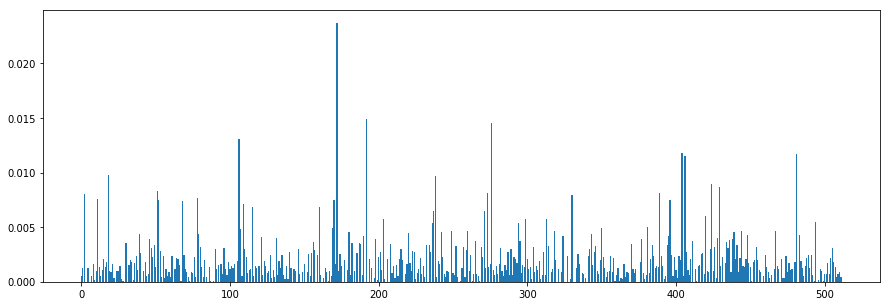

Train Epoch: 381 [0/1800 (0%)]	Loss: 7456.8672
====> Epoch: 381 Average train loss: 0.20546
====> Epoch: 381 Average test loss: 0.16367
Train Epoch: 382 [0/1800 (0%)]	Loss: 6990.9204
====> Epoch: 382 Average train loss: 0.20564
====> Epoch: 382 Average test loss: 0.16374
Train Epoch: 383 [0/1800 (0%)]	Loss: 7420.0317
====> Epoch: 383 Average train loss: 0.20552
====> Epoch: 383 Average test loss: 0.16356
Train Epoch: 384 [0/1800 (0%)]	Loss: 7487.1157
====> Epoch: 384 Average train loss: 0.20520
====> Epoch: 384 Average test loss: 0.16355
Train Epoch: 385 [0/1800 (0%)]	Loss: 6803.3242
====> Epoch: 385 Average train loss: 0.20549
====> Epoch: 385 Average test loss: 0.16375
Train Epoch: 386 [0/1800 (0%)]	Loss: 7233.7788
====> Epoch: 386 Average train loss: 0.20604
====> Epoch: 386 Average test loss: 0.16386
Train Epoch: 387 [0/1800 (0%)]	Loss: 7027.7476
====> Epoch: 387 Average train loss: 0.20544
====> Epoch: 387 Average test loss: 0.16373
Train Epoch: 388 [0/1800 (0%)]	Loss: 6971.7051
=

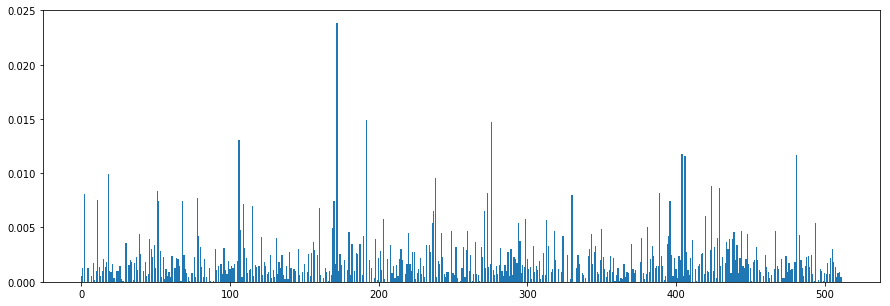

Train Epoch: 391 [0/1800 (0%)]	Loss: 7086.6729
====> Epoch: 391 Average train loss: 0.20548
====> Epoch: 391 Average test loss: 0.16362
Train Epoch: 392 [0/1800 (0%)]	Loss: 6925.7676
====> Epoch: 392 Average train loss: 0.20443
====> Epoch: 392 Average test loss: 0.16359
Train Epoch: 393 [0/1800 (0%)]	Loss: 7181.6909
====> Epoch: 393 Average train loss: 0.20553
====> Epoch: 393 Average test loss: 0.16375
Train Epoch: 394 [0/1800 (0%)]	Loss: 7276.2812
====> Epoch: 394 Average train loss: 0.20529
====> Epoch: 394 Average test loss: 0.16358
Train Epoch: 395 [0/1800 (0%)]	Loss: 7181.1680
====> Epoch: 395 Average train loss: 0.20563
====> Epoch: 395 Average test loss: 0.16368
Train Epoch: 396 [0/1800 (0%)]	Loss: 6991.1499
====> Epoch: 396 Average train loss: 0.20595
====> Epoch: 396 Average test loss: 0.16368
Train Epoch: 397 [0/1800 (0%)]	Loss: 7172.6777
====> Epoch: 397 Average train loss: 0.20580
====> Epoch: 397 Average test loss: 0.16355
Train Epoch: 398 [0/1800 (0%)]	Loss: 7149.3467
=

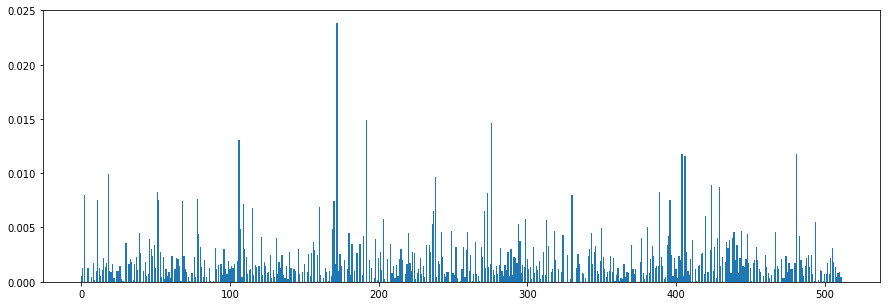

Train Epoch: 401 [0/1800 (0%)]	Loss: 7168.4590
====> Epoch: 401 Average train loss: 0.20557
====> Epoch: 401 Average test loss: 0.16370
Train Epoch: 402 [0/1800 (0%)]	Loss: 6870.0688
====> Epoch: 402 Average train loss: 0.20559
====> Epoch: 402 Average test loss: 0.16371
Train Epoch: 403 [0/1800 (0%)]	Loss: 7244.4556
====> Epoch: 403 Average train loss: 0.20523
====> Epoch: 403 Average test loss: 0.16371
Train Epoch: 404 [0/1800 (0%)]	Loss: 6980.1924
====> Epoch: 404 Average train loss: 0.20584
====> Epoch: 404 Average test loss: 0.16371
Train Epoch: 405 [0/1800 (0%)]	Loss: 7040.3936
====> Epoch: 405 Average train loss: 0.20599
====> Epoch: 405 Average test loss: 0.16374
Train Epoch: 406 [0/1800 (0%)]	Loss: 7112.6646
====> Epoch: 406 Average train loss: 0.20556
====> Epoch: 406 Average test loss: 0.16360
Train Epoch: 407 [0/1800 (0%)]	Loss: 6750.2344
====> Epoch: 407 Average train loss: 0.20625
====> Epoch: 407 Average test loss: 0.16359
Train Epoch: 408 [0/1800 (0%)]	Loss: 7020.4146
=

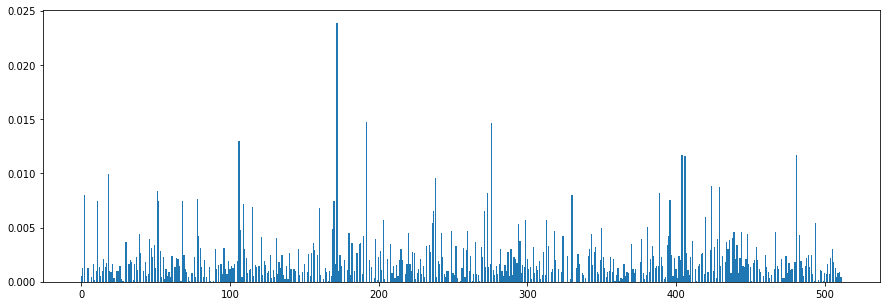

Train Epoch: 411 [0/1800 (0%)]	Loss: 6776.9058
====> Epoch: 411 Average train loss: 0.20533
====> Epoch: 411 Average test loss: 0.16371
Train Epoch: 412 [0/1800 (0%)]	Loss: 6858.7334
====> Epoch: 412 Average train loss: 0.20473
====> Epoch: 412 Average test loss: 0.16367
Train Epoch: 413 [0/1800 (0%)]	Loss: 7063.9824
====> Epoch: 413 Average train loss: 0.20498
====> Epoch: 413 Average test loss: 0.16361
Train Epoch: 414 [0/1800 (0%)]	Loss: 7192.4595
====> Epoch: 414 Average train loss: 0.20506
====> Epoch: 414 Average test loss: 0.16358
Train Epoch: 415 [0/1800 (0%)]	Loss: 6944.6377
====> Epoch: 415 Average train loss: 0.20492
====> Epoch: 415 Average test loss: 0.16361
Train Epoch: 416 [0/1800 (0%)]	Loss: 7452.2412
====> Epoch: 416 Average train loss: 0.20512
====> Epoch: 416 Average test loss: 0.16367
Train Epoch: 417 [0/1800 (0%)]	Loss: 7170.7285
====> Epoch: 417 Average train loss: 0.20532
====> Epoch: 417 Average test loss: 0.16363
Train Epoch: 418 [0/1800 (0%)]	Loss: 7079.2417
=

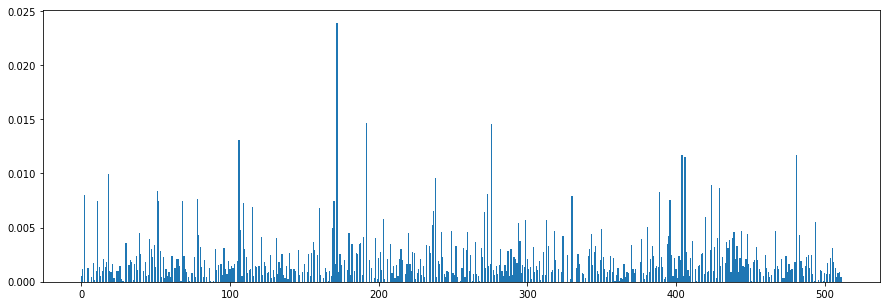

Train Epoch: 421 [0/1800 (0%)]	Loss: 6755.4370
====> Epoch: 421 Average train loss: 0.20544
====> Epoch: 421 Average test loss: 0.16372
Train Epoch: 422 [0/1800 (0%)]	Loss: 6952.9775
====> Epoch: 422 Average train loss: 0.20564
====> Epoch: 422 Average test loss: 0.16366
Train Epoch: 423 [0/1800 (0%)]	Loss: 6901.1230
====> Epoch: 423 Average train loss: 0.20541
====> Epoch: 423 Average test loss: 0.16363
Train Epoch: 424 [0/1800 (0%)]	Loss: 7138.0654
====> Epoch: 424 Average train loss: 0.20553
====> Epoch: 424 Average test loss: 0.16363
Train Epoch: 425 [0/1800 (0%)]	Loss: 6520.6802
====> Epoch: 425 Average train loss: 0.20555
====> Epoch: 425 Average test loss: 0.16378
Train Epoch: 426 [0/1800 (0%)]	Loss: 6983.8901
====> Epoch: 426 Average train loss: 0.20578
====> Epoch: 426 Average test loss: 0.16376
Train Epoch: 427 [0/1800 (0%)]	Loss: 7240.7686
====> Epoch: 427 Average train loss: 0.20471
====> Epoch: 427 Average test loss: 0.16352
Train Epoch: 428 [0/1800 (0%)]	Loss: 7153.3389
=

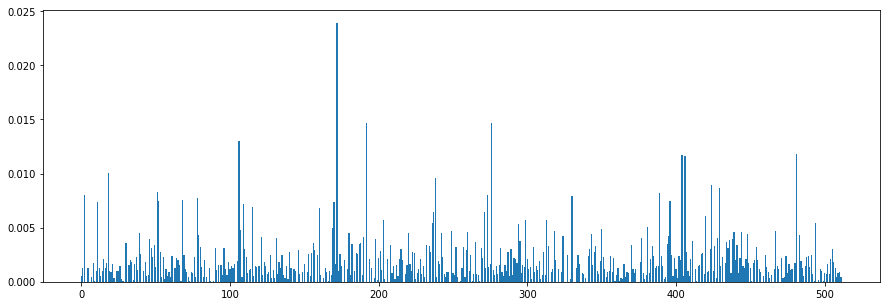

Train Epoch: 431 [0/1800 (0%)]	Loss: 6926.3306
====> Epoch: 431 Average train loss: 0.20560
====> Epoch: 431 Average test loss: 0.16384
Train Epoch: 432 [0/1800 (0%)]	Loss: 7237.3799
====> Epoch: 432 Average train loss: 0.20624
====> Epoch: 432 Average test loss: 0.16358
Train Epoch: 433 [0/1800 (0%)]	Loss: 7355.9814
====> Epoch: 433 Average train loss: 0.20509
====> Epoch: 433 Average test loss: 0.16365
Train Epoch: 434 [0/1800 (0%)]	Loss: 6976.6597
====> Epoch: 434 Average train loss: 0.20584
====> Epoch: 434 Average test loss: 0.16368
Train Epoch: 435 [0/1800 (0%)]	Loss: 7228.9229
====> Epoch: 435 Average train loss: 0.20517
====> Epoch: 435 Average test loss: 0.16373
Train Epoch: 436 [0/1800 (0%)]	Loss: 7070.5239
====> Epoch: 436 Average train loss: 0.20539
====> Epoch: 436 Average test loss: 0.16364
Train Epoch: 437 [0/1800 (0%)]	Loss: 6776.7466
====> Epoch: 437 Average train loss: 0.20555
====> Epoch: 437 Average test loss: 0.16356
Train Epoch: 438 [0/1800 (0%)]	Loss: 6787.4072
=

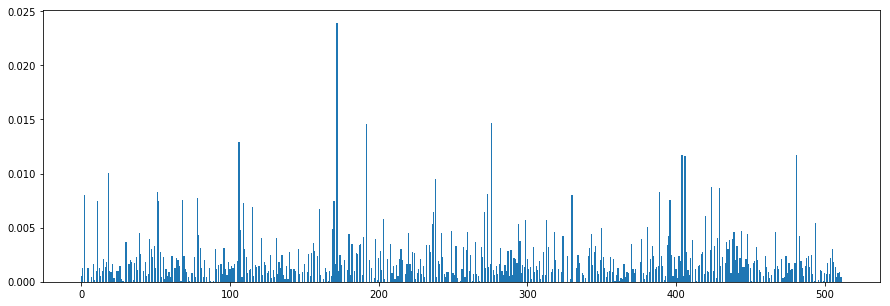

Train Epoch: 441 [0/1800 (0%)]	Loss: 6783.5557
====> Epoch: 441 Average train loss: 0.20539
====> Epoch: 441 Average test loss: 0.16364
Train Epoch: 442 [0/1800 (0%)]	Loss: 7577.6558
====> Epoch: 442 Average train loss: 0.20674
====> Epoch: 442 Average test loss: 0.16362
Train Epoch: 443 [0/1800 (0%)]	Loss: 6824.1489
====> Epoch: 443 Average train loss: 0.20524
====> Epoch: 443 Average test loss: 0.16372
Train Epoch: 444 [0/1800 (0%)]	Loss: 7284.9136
====> Epoch: 444 Average train loss: 0.20526
====> Epoch: 444 Average test loss: 0.16348
Train Epoch: 445 [0/1800 (0%)]	Loss: 7387.4771
====> Epoch: 445 Average train loss: 0.20525
====> Epoch: 445 Average test loss: 0.16368
Train Epoch: 446 [0/1800 (0%)]	Loss: 7033.2217
====> Epoch: 446 Average train loss: 0.20551
====> Epoch: 446 Average test loss: 0.16367
Train Epoch: 447 [0/1800 (0%)]	Loss: 7052.2935
====> Epoch: 447 Average train loss: 0.20532
====> Epoch: 447 Average test loss: 0.16369
Train Epoch: 448 [0/1800 (0%)]	Loss: 6931.4224
=

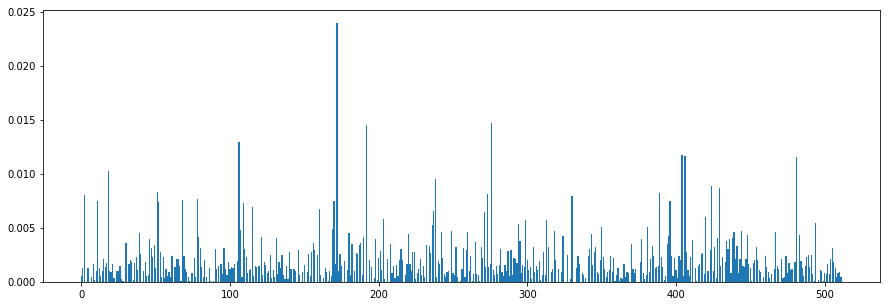

--- 731.0124826431274 seconds ---
Minimal train/testing losses are 0.2053 and 0.1635 with index 443



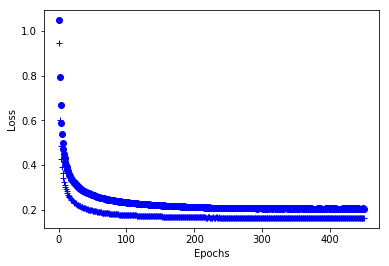

In [147]:
epochs = 450
start_time = time.time()

for epoch in range(1, epochs + 1):
    scheduler.step()
    
    train_loss = train(epoch)
    test_loss, _, _ = test(epoch)
    save_model(test_loss, train_loss)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    
print("--- %s seconds ---" % (time.time() - start_time))
print('Minimal train/testing losses are {:.4f} and {:.4f} with index {}\n'
    .format(cur_train_loss, best_val_loss, test_loss_history.index(min(test_loss_history))))

# plot train and test loss against epochs
plt.figure(1)
epoch_axis = range(1, len(train_loss_history) + 1)
plt.plot(epoch_axis, train_loss_history, 'bo')
plt.plot(epoch_axis, test_loss_history, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [148]:
# data = next(iter(train_loader))
# data = data.to(gpu)
# out, _, _ = model(data)
# model.load_state_dict(torch.load('./cae_models/spk_vq_vae_easy1_N16.pt'))

<Figure size 432x288 with 0 Axes>

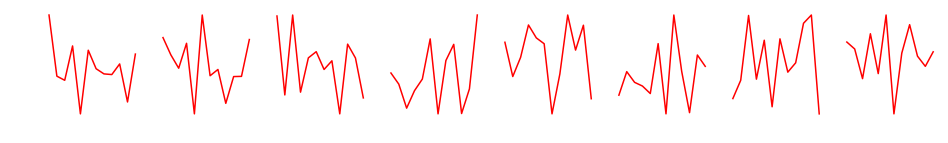

In [149]:
# plt.figure()
# n_row, n_col = 8, 8
# f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*1.5, n_row*1.5))
# cur_ker = model.embed.weight.data.cpu().numpy()
# for i in range(n_row):
#     for j in range(n_col):
#         axarr[i, j].plot(cur_ker[i*n_row+j], 'r')
#         axarr[i, j].axis('off')
# plt.show()

model.load_state_dict(torch.load('./spk_vq_vae_temp.pt'))
#torch.save(model.state_dict(), './cae_models/spk_vq_vae_hc1_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))
torch.save(model.state_dict(), './cae_models/spk_vq_vae_neuropixels_c15r_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))
#torch.save(model.state_dict(), './cae_models/spk_vq_vae_waveclus_vq{}_N{}.pt'.format(vq_num, param_resnet_v2[2]))

embed_idx = np.argsort(model.embed_freq)
embed_sort = model.embed.weight.data.cpu().numpy()[embed_idx]

plt.figure()
n_row, n_col = 1, 8
f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(8):
    axarr[i].plot(embed_sort[i], 'r')
    axarr[i].axis('off')
plt.show()

In [150]:
# %% spike recon
train_mean, train_std, _ = helper.param_for_recon()
train_mean, train_std = torch.from_numpy(train_mean), torch.from_numpy(train_std)
_, val_spks, test_spks = test(9)

# val_spks = val_spks.numpy()
# test_spks = test_spks.numpy()

# calculate compression ratio
vq_freq = model.embed_freq / sum(model.embed_freq)
vq_freq = vq_freq[vq_freq != 0]
vq_log2 = np.log2(vq_freq)
bits = -sum(np.multiply(vq_freq, vq_log2))
cr = spk_ch * spk_dim * 16 / (param_resnet_v2[2] * bits)
print('compression ratio is {:.2f} with {:.2f}-bit.'.format(cr, bits))

====> Epoch: 9 Average test loss: 0.16348
compression ratio is 11.63 with 8.25-bit.


In [151]:
#xx = np.linalg.norm(test_spks_new, axis=1)
# def cal_sndr(org_data, recon_data):
#     org_norm = np.linalg.norm(org_data, axis=1)
#     err_norm = np.linalg.norm(org_data-recon_data, axis=1)
#     return np.mean(20*np.log10(org_norm / err_norm))

recon_spks = (val_spks * train_std + train_mean).view(-1, spk_dim)
test_spks_v2 = (test_spks * train_std + train_mean).view(-1, spk_dim)

# xx = F.mse_loss(recon_spks, test_spks_v2, reduce=False, size_average=True)
# xx = xx.view(-1, spk_dim)
# xx = torch.mean(xx, dim=1)

recon_err = torch.norm(recon_spks-test_spks_v2, p=2, dim=1) / torch.norm(test_spks_v2, p=2, dim=1)

print('mean of recon_err is {:.4f}'.format(torch.mean(recon_err)))
print('std of recon_err is {:.4f}'.format(torch.std(recon_err)))

mean of recon_err is 0.3818
std of recon_err is 0.1573


In [152]:
# %% spike visualization for 3-d inputs
recon_spks_new = recon_spks.numpy()
test_spks_new = test_spks_v2.numpy()

def cal_sndr(org_data, recon_data):
    org_norm = np.linalg.norm(org_data, axis=1)
    err_norm = np.linalg.norm(org_data-recon_data, axis=1)
    return np.mean(20*np.log10(org_norm / err_norm)), np.std(20*np.log10(org_norm / err_norm))

cur_sndr, sndr_std = cal_sndr(test_spks_new, recon_spks_new)
print('SNDR is {:.4f} with std {:.4f}'.format(cur_sndr, sndr_std))

SNDR is 9.0601 with std 3.4882


<Figure size 432x288 with 0 Axes>

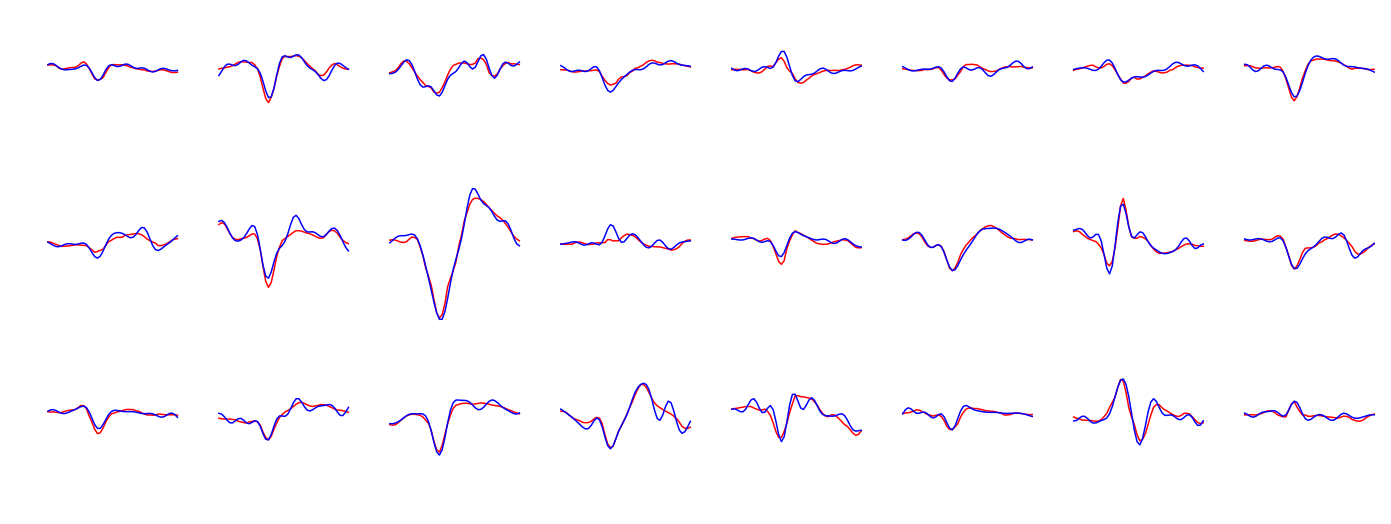

In [153]:
rand_val_idx = np.random.permutation(len(recon_spks_new))

plt.figure()
n_row, n_col = 3, 8
spks_to_show = test_spks_new[rand_val_idx[:n_row*n_col]]
ymax, ymin = np.amax(spks_to_show), np.amin(spks_to_show)
f, axarr = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*3))
for i in range(n_row):
    for j in range(n_col):
        axarr[i, j].plot(recon_spks_new[rand_val_idx[i*n_col+j]], 'r')
        axarr[i, j].plot(test_spks_new[rand_val_idx[i*n_col+j]], 'b')
        axarr[i, j].set_ylim([ymin*1.1, ymax*1.1])
        axarr[i, j].axis('off')
#plt.show()
#plt.savefig('waveclus_spks.eps', format='eps', dpi=600)